In [1]:
import os
os.environ['YT_DEST'] = '/home/kwoksun2/anaconda2/pkgs/yt-3.3.5-np111py27_2/'
import numpy as np
from dengo.chemical_network import \
    ChemicalNetwork, \
    reaction_registry, \
    cooling_registry, species_registry
import dengo.primordial_rates, dengo.primordial_cooling
from dengo.chemistry_constants import tiny, kboltz, mh
import yt
import yt.units as u
import numpy
import pickle
import pyximport
import h5py
import timeit
import time
from generate_dls_cooling_network import create_cvdls_solver, Init_values
import matplotlib.pyplot as plt

 using cli
 using CLI for selections


In [2]:
import os, sys

class HidePrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout = self._original_stdout

# Evolve Free Fall Parcel

1. let the gas cool at constant density from the starting temperature down to a lower temperature to get the species fractions in a resonable state
2. evolve density and temperature according to freefall collapse

In [3]:
init, primordial = Init_values(np.array([2000.0]), np.array([1e10]) , n_species = 9, cooling=True)

Adding reaction: k01 : 1*H_1 + 1*de => 1*H_2 + 2*de
Adding reaction: k02 : 1*H_2 + 1*de => 1*H_1
Adding reaction: k03 : 1*He_1 + 1*de => 1*He_2 + 2*de
Adding reaction: k04 : 1*He_2 + 1*de => 1*He_1
Adding reaction: k05 : 1*He_2 + 1*de => 1*He_3 + 2*de
Adding reaction: k06 : 1*He_3 + 1*de => 1*He_2
Adding reaction: k07 : 1*H_1 + 1*de => 1*H_m0
Adding reaction: k08 : 1*H_m0 + 1*H_1 => 1*H2_1 + 1*de
Adding reaction: k09 : 1*H_1 + 1*H_2 => 1*H2_2
Adding reaction: k10 : 1*H2_2 + 1*H_1 => 1*H2_1 + 1*H_2
Adding reaction: k11 : 1*H2_1 + 1*H_2 => 1*H2_2 + 1*H_1
Adding reaction: k12 : 1*H2_1 + 1*de => 2*H_1 + 1*de
Adding reaction: k13 : 1*H2_1 + 1*H_1 => 3*H_1
Adding reaction: k14 : 1*H_m0 + 1*de => 1*H_1 + 2*de
Adding reaction: k15 : 1*H_m0 + 1*H_1 => 2*H_1 + 1*de
Adding reaction: k16 : 1*H_m0 + 1*H_2 => 2*H_1
Adding reaction: k17 : 1*H_m0 + 1*H_2 => 1*H2_2 + 1*de
Adding reaction: k18 : 1*H2_2 + 1*de => 2*H_1
Adding reaction: k19 : 1*H2_2 + 1*H_m0 => 1*H_1 + 1*H2_1
Adding reaction: k21 : 2*H_1 

In [4]:
primordial.cooling_actions

{'brem': <dengo.reaction_classes.CoolingAction at 0x7f6fc925f590>,
 'ceHI': <dengo.reaction_classes.CoolingAction at 0x7f6fc925f210>,
 'ceHeI': <dengo.reaction_classes.CoolingAction at 0x7f6fc925f310>,
 'ceHeII': <dengo.reaction_classes.CoolingAction at 0x7f6fc925f350>,
 'ciHI': <dengo.reaction_classes.CoolingAction at 0x7f6fc925f3d0>,
 'ciHeI': <dengo.reaction_classes.CoolingAction at 0x7f6fc925f410>,
 'ciHeII': <dengo.reaction_classes.CoolingAction at 0x7f6fc925f450>,
 'ciHeIS': <dengo.reaction_classes.CoolingAction at 0x7f6fc925f390>,
 'compton': <dengo.reaction_classes.CoolingAction at 0x7f6fc925f610>,
 'gammah': <dengo.reaction_classes.CoolingAction at 0x7f6fc925f650>,
 'gloverabel08': <dengo.reaction_classes.CoolingAction at 0x7f6fc925f5d0>,
 'h2formation': <dengo.reaction_classes.CoolingAction at 0x7f6fc925f690>,
 'reHII': <dengo.reaction_classes.CoolingAction at 0x7f6fc925f490>,
 'reHeII1': <dengo.reaction_classes.CoolingAction at 0x7f6fc925f4d0>,
 'reHeII2': <dengo.reaction_cl

In [5]:
def calculate_pressure(init, primordial):
    P = numpy.zeros((1))
    T = init['T']
    for sp in primordial.required_species:
        if sp.name != 'ge':
            n_sp = init[sp.name]/sp.weight
            P += n_sp * u.boltzmann_constant_cgs.v * T
    return P

def calculate_collapse_factor(pressure, density):
    # Calculate the effective adiabatic index, dlog(p)/dlog(rho).
    if len(pressure) < 3:
        return 0.

    # compute dlog(p) / dlog(rho) using last two timesteps
    gamma_eff = np.log10(pressure[-1] / pressure[-2]) / \
        np.log10(density[-1] / density[-2])
    
    # compute a higher order derivative if more than two points available
    if len(pressure) > 2:
        gamma_eff += 0.5 * ((np.log10(pressure[-2] / pressure[-3]) /
                             np.log10(density[-2] / density[-3])) - gamma_eff)

    gamma_eff = min(gamma_eff, 4./3.)

    # Equation 9 of Omukai et al. (2005)
    if gamma_eff < 0.83:
        force_factor = 0.0
    elif gamma_eff < 1.0:
        force_factor = 0.6 + 2.5 * (gamma_eff - 1) - \
            6.0 * np.power((gamma_eff - 1.0), 2.)
    else:
        force_factor = 1.0 + 0.2 * (gamma_eff - (4./3.)) - \
            2.9 * np.power((gamma_eff - (4./3.)), 2.)

    force_factor = max(force_factor, 0.0)
    force_factor = min(force_factor, 0.95)
    return force_factor

def calculate_gamma(init, primordial):
    gamma = 5.0/3.0
    for sp in primordial.required_species: 
        if sp.name == 'H2_1':
            sp_H2 = sp
            break
    gammaH2 = primordial.species_gamma(sp, temp=True).subs({'T':temperature})

    gamma_fac = primordial.gamma_factor()
    gamma_factor = gamma_fac.subs(init).subs({'gamma':gamma}).subs({'gammaH2':gammaH2})

    n_density = 0.0
    for sp in primordial.required_species:
        if sp.name != 'ge':
            n_density += init[sp.name]

    gamma_ad = n_density/gamma_factor + 1
    gamma_ad = float(gamma_ad)
    return gamma_ad



def calculate_temperature(init, primordial):
    dT = 10.0
    temperature = init['T']
        
    while dT > 0.1:
        x = 6100.0/temperature
        # update the gammaH2 which is dependent on temperature
        gammaH2 = 2.0 / (5.0 + 2.0*x*x*numpy.exp(x) / (numpy.exp(x) - 1 )**2.0 ) + 1

        gamma_factor = primordial.gamma_factor().subs(init).subs({'gammaH2': gammaH2 , 'gamma': 5./3.,'T':temperature })
        
        # with ge updated from compressional heating
        ge = init['ge']
        
        new_T = numpy.array([float(init['density']*ge*mh / kboltz / gamma_factor)])
        dT = numpy.abs(new_T - temperature)
        temperature = new_T
        
    return new_T

def calculate_energy(init, primordial):
    """Calculate energy from the abundance and temperature
    """
    num_den = {}
    for sp in primordial.required_species:
        try:
            num_den[sp.name] = init[sp.name]/ sp.weight
        except:
            pass

    # set up initial temperatures values used to define ge
    temperature = init['T']

    # calculate gammaH2
    x = 6100.0/temperature
    gammaH2 = 2.0 / (5.0 + 2.0*x*x*numpy.exp(x) / (numpy.exp(x) - 1 )**2.0 ) + 1

    gamma_factor = primordial.gamma_factor().subs(num_den).subs({'gammaH2': gammaH2 , 'gamma': 5./3.,'T': temperature })

    ge  = ((temperature *  kboltz) *gamma_factor
                         / (init['density'] * mh  ))

    T = init['density']*ge*mh / kboltz / gamma_factor
    
    print(T-temperature)
    
    return numpy.array( [numpy.float64(ge)] )


In [6]:
def update_initial_condition(init, primordial, pressure_array, density_array, safety_factor=0.01):
    
    # should be in cgs units
    # dyne / cm^-2
    current_pressure = calculate_pressure(init, primordial)
    pressure_array = numpy.append(pressure_array, current_pressure)    
    
    
    include_pressure = False
    if include_pressure:
        force_factor = calculate_collapse_factor(pressure_array, density_array)
    else:
        force_factor = 0.0    
    print("force_factor: {}".format(force_factor))
    
    density = init['density']
    
    # compute the new density using the modified
    # free-fall collapse as per Omukai et al. (2005)

    gravitational_constant = 4.0*numpy.pi*6.65259e-8 *  u.amu_cgs.v
    freefall_time_constant = np.power((( 32.0*gravitational_constant)/ (3.0*numpy.pi)), 0.5)

    dt = safety_factor* np.power( (3.0*np.pi)/ (32.0* gravitational_constant *density ), 0.5 )

    # calculate new density from altered free-fall solution
    
    new_density = np.power((np.power(density, -0.5) -
                                (0.5 * freefall_time_constant * dt *
                                 np.power((1 - force_factor), 0.5))), -2.)
    
    # multiply this with the elemental abundances
    density_ratio = new_density/density

    # update densities
    # only update the species array only
    for sp in primordial.required_species:
        if sp.name != 'ge':
            init[sp.name] *= density_ratio

    Gamma = calculate_gamma(init, primordial)
    
    # update internal energy
    init['ge'] += (Gamma - 1.0) * init['ge'] * \
                        freefall_time_constant* \
                        new_density**0.5 * dt
            
    print( "gammma - 1: {}".format((Gamma - 1.0)))
    # update density
    init['density'] = new_density
    density_array = numpy.append(density_array, new_density)
    
    
    # update temperature with the updated internal energy
    init['T'] = calculate_temperature(init, primordial)
    
    return init, pressure_array, density_array, dt, force_factor


def generate_init_from_results(rv_int, primordial, old_init):
    flag = rv_int['successful']
    init = {}
    for sp in primordial.required_species:
        print(sp)
        init[sp.name] = rv_int[sp.name][0][flag][-1]*sp.weight
    density = old_init['density']
    init['density'] = density
    init['T'] = numpy.array([rv_int['T'][0][flag][-1]])
    return init


def convert_from_grackle_to_dengo(grackle_dict):
    dengo_dict = {}
    for key in grackle_dict:
        key = str(key)
        
        ele = key.split('I')[0]
        charge = key.count('I')
        if charge > 0:
            dengo_name = ele+ '_' + str(charge)
            dengo_dict[dengo_name] = numpy.array(grackle_dict[key][0])/u.amu_cgs.v
        elif 'M' in key:
            ele = key.split('M')[0]
            dengo_name = ele + '_' + str("m0")
            dengo_dict[dengo_name] = numpy.array(grackle_dict[key][0])/u.amu_cgs.v
        elif key == 'temperature':
            dengo_name = 'T'
            dengo_dict[dengo_name] = numpy.array(grackle_dict[key][0])
        elif key == 'de':
            dengo_name = 'de'
            dengo_dict[dengo_name] = numpy.array(grackle_dict[key][0])/u.amu_cgs.v
    return dengo_dict


def convert_from_grackle_to_dengo_all(grackle_dict):
    dengo_dict = {}
    for key in grackle_dict:
        key = str(key)
        
        ele = key.split('I')[0]
        charge = key.count('I')
        if charge > 0:
            dengo_name = ele+ '_' + str(charge)
            if ele == 'H':
                dengo_dict[dengo_name] = numpy.array(grackle_dict[key])/u.amu_cgs.v / 1.00794
            elif ele == 'He':
                dengo_dict[dengo_name] = numpy.array(grackle_dict[key])/u.amu_cgs.v / 4.002602
            elif ele == 'H2':
                dengo_dict[dengo_name] = numpy.array(grackle_dict[key])/u.amu_cgs.v / 1.00794 /2.0
        elif 'M' in key:
            ele = key.split('M')[0]
            dengo_name = ele + '_' + str("m0")
            dengo_dict[dengo_name] = numpy.array(grackle_dict[key])/u.amu_cgs.v
        elif key == 'temperature':
            dengo_name = 'T'
            dengo_dict[dengo_name] = numpy.array(grackle_dict[key])
        elif key == 'de':
            dengo_name = 'de'
            dengo_dict[dengo_name] = numpy.array(grackle_dict[key])/u.amu_cgs.v
    return dengo_dict

In [229]:
# Initial conditions
temperature = 20000.0# K
density = 1.0e-1 # cm^-3

solver_name = 'cvdls_9species'
with HidePrints():
    init, primordial = Init_values(np.array([temperature]), np.array([density]) , n_species = 9
                                   , cooling=True)

chemistry_run = create_cvdls_solver(init,primordial, solver_name, cooling=True);


three body rate: 4


In [230]:
temperature = 50000.0# K
density = 1.0e-1*1.00794 # cm^-3

with HidePrints():
    init, primordial = Init_values(np.array([temperature]), np.array([density]) , n_species = 9)
rv, rv_int = chemistry_run.run_cvdls_9species(init, 5.0e17,niter=1e3);

initial  temperature: 5.000E+04
Successful iteration[  100]: (1.381e+14) 1.520e+15 / 5.000e+17
End in 193 iterations: 5.00000e+17 / 5.00000e+17 (0.00000e+00)


111.6465515126628

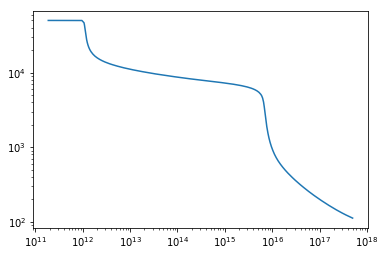

In [231]:
flag = rv_int['successful']
plt.loglog(rv_int['t'][flag],rv_int['T'][0][flag])
rv_int['T'][0][flag][-1]

In [235]:
total_t = 0.0
final_density = 1.0e12*1.00794
density_array = numpy.array([ init['density'] ])
pressure_array = numpy.array([])
ttt = []
run_time = []
current_density = density_array[-1]

all_data = {}
for key in init.keys():
    all_data[key] = []
all_data['force_factor'] = []

In [236]:
dir_ff_grackle = "/home/kwoksun2/grackle/src/python/examples/freefall.h5"
import h5py
f = h5py.File(dir_ff_grackle)
fdata = f['data']
grackle_init = convert_from_grackle_to_dengo(fdata)


new_init, primordial = Init_values(np.array([temperature]), np.array([density]) , n_species = 9)
for i in new_init.keys():
    if i not in ['density','ge']:
        print(i, grackle_init[i]) 
        new_init[i] = numpy.array([grackle_init[i]])

new_init['de'] = primordial.calculate_free_electrons(new_init)
new_init['ge'] =  calculate_energy(new_init, primordial)
rv, rv_int = chemistry_run.run_cvdls_9species(new_init, 1e-5,niter=1e0)

Adding reaction: k01 : 1*H_1 + 1*de => 1*H_2 + 2*de
Adding reaction: k02 : 1*H_2 + 1*de => 1*H_1
Adding reaction: k03 : 1*He_1 + 1*de => 1*He_2 + 2*de
Adding reaction: k04 : 1*He_2 + 1*de => 1*He_1
Adding reaction: k05 : 1*He_2 + 1*de => 1*He_3 + 2*de
Adding reaction: k06 : 1*He_3 + 1*de => 1*He_2
Adding reaction: k07 : 1*H_1 + 1*de => 1*H_m0
Adding reaction: k08 : 1*H_m0 + 1*H_1 => 1*H2_1 + 1*de
Adding reaction: k09 : 1*H_1 + 1*H_2 => 1*H2_2
Adding reaction: k10 : 1*H2_2 + 1*H_1 => 1*H2_1 + 1*H_2
Adding reaction: k11 : 1*H2_1 + 1*H_2 => 1*H2_2 + 1*H_1
Adding reaction: k12 : 1*H2_1 + 1*de => 2*H_1 + 1*de
Adding reaction: k13 : 1*H2_1 + 1*H_1 => 3*H_1
Adding reaction: k14 : 1*H_m0 + 1*de => 1*H_1 + 2*de
Adding reaction: k15 : 1*H_m0 + 1*H_1 => 2*H_1 + 1*de
Adding reaction: k16 : 1*H_m0 + 1*H_2 => 2*H_1
Adding reaction: k17 : 1*H_m0 + 1*H_2 => 1*H2_2 + 1*de
Adding reaction: k18 : 1*H2_2 + 1*de => 2*H_1
Adding reaction: k19 : 1*H2_2 + 1*H_m0 => 1*H_1 + 1*H2_1
Adding reaction: k21 : 2*H_1 

In [237]:
flag = rv_int['successful']
de = numpy.zeros((1))
for sp in new_init.keys():
    if sp not in ['de','density','ge','T']:
        s = species_registry[sp]
        print(s.name)
        de += rv_int[s.name][0][flag][-1]  * s.free_electrons

H_2
H_1
He_1
He_2
He_3
H2_2
H2_1
H_m0


In [238]:
while current_density < final_density:

    # keep track of time in here
    
    new_init = generate_init_from_results(rv_int,primordial, new_init)
    init, pressure_array, density_array, dt, force_factor = update_initial_condition(new_init, primordial, pressure_array
                                                             , density_array, safety_factor=0.01)
    tic = time.time()
    rv, rv_int = chemistry_run.run_cvdls_9species(init, dt,niter=1e3)
    toc = time.time()
    total_t += dt
    ttt.append(float(total_t))
    run_time.append(toc-tic)
    
    flag = rv_int['successful']
    for key in init.keys():
        if key not in ['density']:
            data = rv_int[key][0][flag][-1]
            all_data[key].append(data)
    all_data['force_factor'].append( float(force_factor))
    current_density = density_array[-1]

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917811053
initial  temperature: 8.180E+01
Successful iteration[    0]: (1.451e+10) 1.451e+10 / 1.451e+13
End in 49 iterations: 1.45084e+13 / 1.45084e+13 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917810636
initial  temperature: 8.234E+01
Successful iteration[    0]: (1.444e+10) 1.444e+10 / 1.444e+13
End in 49 iterations: 1.44358e+13 / 1.44358e+13 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917810213
initial  temperature: 8.289E+01
Successful iteration[    0]: (1.436e+10) 1.436e+10 / 1.436e+13
End in 49 iterations: 1.43636e+13 / 1.43636e+13 (0.000

Species: H_2
force_factor: 0.0
gammma - 1: 0.66491779961
initial  temperature: 9.596E+01
Successful iteration[    0]: (1.286e+10) 1.286e+10 / 1.286e+13
End in 49 iterations: 1.28639e+13 / 1.28639e+13 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917799063
initial  temperature: 9.660E+01
Successful iteration[    0]: (1.280e+10) 1.280e+10 / 1.280e+13
End in 49 iterations: 1.27996e+13 / 1.27996e+13 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66491779851
initial  temperature: 9.724E+01
Successful iteration[    0]: (1.274e+10) 1.274e+10 / 1.274e+13
End in 49 iterations: 1.27356e+13 / 1.27356e+13 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Specie

Successful iteration[    0]: (1.141e+10) 1.141e+10 / 1.141e+13
End in 49 iterations: 1.14058e+13 / 1.14058e+13 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917783914
initial  temperature: 1.133E+02
Successful iteration[    0]: (1.135e+10) 1.135e+10 / 1.135e+13
End in 49 iterations: 1.13488e+13 / 1.13488e+13 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66491778319
initial  temperature: 1.140E+02
Successful iteration[    0]: (1.129e+10) 1.129e+10 / 1.129e+13
End in 49 iterations: 1.12920e+13 / 1.12920e+13 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917782458
initial  temperature: 1.1

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917764099
initial  temperature: 1.328E+02
Successful iteration[    0]: (1.006e+10) 1.006e+10 / 1.006e+13
End in 49 iterations: 1.00624e+13 / 1.00624e+13 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917763152
initial  temperature: 1.337E+02
Successful iteration[    0]: (1.001e+10) 1.001e+10 / 1.001e+13
End in 49 iterations: 1.00121e+13 / 1.00121e+13 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917762195
initial  temperature: 1.346E+02
Successful iteration[    0]: (9.962e+09) 9.962e+09 / 9.962e+12
End in 49 iterations: 9.96207e+12 / 9.96207e+12 (0.000

Species: H_2
force_factor: 0.0
gammma - 1: 0.664917738204
initial  temperature: 1.556E+02
Successful iteration[    0]: (8.922e+09) 8.922e+09 / 8.922e+12
End in 49 iterations: 8.92190e+12 / 8.92190e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917736967
initial  temperature: 1.566E+02
Successful iteration[    0]: (8.877e+09) 8.877e+09 / 8.877e+12
End in 49 iterations: 8.87729e+12 / 8.87729e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917735717
initial  temperature: 1.576E+02
Successful iteration[    0]: (8.833e+09) 8.833e+09 / 8.833e+12
End in 49 iterations: 8.83290e+12 / 8.83290e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Spec

Successful iteration[    0]: (7.911e+09) 7.911e+09 / 7.911e+12
End in 49 iterations: 7.91063e+12 / 7.91063e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917702798
initial  temperature: 1.832E+02
Successful iteration[    0]: (7.871e+09) 7.871e+09 / 7.871e+12
End in 49 iterations: 7.87108e+12 / 7.87108e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917701169
initial  temperature: 1.844E+02
Successful iteration[    0]: (7.832e+09) 7.832e+09 / 7.832e+12
End in 49 iterations: 7.83172e+12 / 7.83172e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917699521
initial  temperature: 1.

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917658303
initial  temperature: 2.139E+02
Successful iteration[    0]: (6.979e+09) 6.979e+09 / 6.979e+12
End in 49 iterations: 6.97892e+12 / 6.97892e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917656184
initial  temperature: 2.153E+02
Successful iteration[    0]: (6.944e+09) 6.944e+09 / 6.944e+12
End in 49 iterations: 6.94402e+12 / 6.94402e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917654041
initial  temperature: 2.167E+02
Successful iteration[    0]: (6.909e+09) 6.909e+09 / 6.909e+12
End in 49 iterations: 6.90930e+12 / 6.90930e+12 (0.000

Species: H_2
force_factor: 0.0
gammma - 1: 0.664917600536
initial  temperature: 2.490E+02
Successful iteration[    0]: (6.188e+09) 6.188e+09 / 6.188e+12
End in 49 iterations: 6.18788e+12 / 6.18788e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66491759779
initial  temperature: 2.505E+02
Successful iteration[    0]: (6.157e+09) 6.157e+09 / 6.157e+12
End in 49 iterations: 6.15694e+12 / 6.15694e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917595014
initial  temperature: 2.521E+02
Successful iteration[    0]: (6.126e+09) 6.126e+09 / 6.126e+12
End in 49 iterations: 6.12616e+12 / 6.12616e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Speci

Successful iteration[    0]: (5.487e+09) 5.487e+09 / 5.487e+12
End in 49 iterations: 5.48651e+12 / 5.48651e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66491752233
initial  temperature: 2.901E+02
Successful iteration[    0]: (5.459e+09) 5.459e+09 / 5.459e+12
End in 49 iterations: 5.45908e+12 / 5.45908e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917518753
initial  temperature: 2.919E+02
Successful iteration[    0]: (5.432e+09) 5.432e+09 / 5.432e+12
End in 49 iterations: 5.43178e+12 / 5.43178e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917515139
initial  temperature: 2.9

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917425453
initial  temperature: 3.334E+02
Successful iteration[    0]: (4.840e+09) 4.840e+09 / 4.840e+12
End in 49 iterations: 4.84031e+12 / 4.84031e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917420881
initial  temperature: 3.353E+02
Successful iteration[    0]: (4.816e+09) 4.816e+09 / 4.816e+12
End in 49 iterations: 4.81611e+12 / 4.81611e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917416262
initial  temperature: 3.372E+02
Successful iteration[    0]: (4.792e+09) 4.792e+09 / 4.792e+12
End in 49 iterations: 4.79203e+12 / 4.79203e+12 (0.000

Species: H_2
force_factor: 0.0
gammma - 1: 0.664917302245
initial  temperature: 3.789E+02
Successful iteration[    0]: (4.292e+09) 4.292e+09 / 4.292e+12
End in 49 iterations: 4.29168e+12 / 4.29168e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917296464
initial  temperature: 3.808E+02
Successful iteration[    0]: (4.270e+09) 4.270e+09 / 4.270e+12
End in 49 iterations: 4.27022e+12 / 4.27022e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917290628
initial  temperature: 3.827E+02
Successful iteration[    0]: (4.249e+09) 4.249e+09 / 4.249e+12
End in 49 iterations: 4.24887e+12 / 4.24887e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Spec

Successful iteration[    0]: (3.805e+09) 3.805e+09 / 3.805e+12
End in 49 iterations: 3.80523e+12 / 3.80523e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917140424
initial  temperature: 4.254E+02
Successful iteration[    0]: (3.786e+09) 3.786e+09 / 3.786e+12
End in 49 iterations: 3.78620e+12 / 3.78620e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917133166
initial  temperature: 4.271E+02
Successful iteration[    0]: (3.767e+09) 3.767e+09 / 3.767e+12
End in 49 iterations: 3.76727e+12 / 3.76727e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917125844
initial  temperature: 4.

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664916948268
initial  temperature: 4.646E+02
Successful iteration[    0]: (3.357e+09) 3.357e+09 / 3.357e+12
End in 49 iterations: 3.35705e+12 / 3.35705e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664916939427
initial  temperature: 4.660E+02
Successful iteration[    0]: (3.340e+09) 3.340e+09 / 3.340e+12
End in 49 iterations: 3.34027e+12 / 3.34027e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664916930517
initial  temperature: 4.674E+02
Successful iteration[    0]: (3.324e+09) 3.324e+09 / 3.324e+12
End in 49 iterations: 3.32356e+12 / 3.32356e+12 (0.000

Species: H_2
force_factor: 0.0
gammma - 1: 0.66491671699
initial  temperature: 4.938E+02
Successful iteration[    0]: (2.977e+09) 2.977e+09 / 2.977e+12
End in 49 iterations: 2.97654e+12 / 2.97654e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664916706482
initial  temperature: 4.947E+02
Successful iteration[    0]: (2.962e+09) 2.962e+09 / 2.962e+12
End in 49 iterations: 2.96166e+12 / 2.96166e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664916695904
initial  temperature: 4.956E+02
Successful iteration[    0]: (2.947e+09) 2.947e+09 / 2.947e+12
End in 49 iterations: 2.94685e+12 / 2.94685e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Speci

Successful iteration[    0]: (2.639e+09) 2.639e+09 / 2.639e+12
End in 49 iterations: 2.63916e+12 / 2.63916e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664916433356
initial  temperature: 5.106E+02
Successful iteration[    0]: (2.626e+09) 2.626e+09 / 2.626e+12
End in 49 iterations: 2.62596e+12 / 2.62596e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664916421108
initial  temperature: 5.110E+02
Successful iteration[    0]: (2.613e+09) 2.613e+09 / 2.613e+12
End in 49 iterations: 2.61284e+12 / 2.61284e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664916408792
initial  temperature: 5.

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664916120547
initial  temperature: 5.143E+02
Successful iteration[    0]: (2.328e+09) 2.328e+09 / 2.328e+12
End in 49 iterations: 2.32832e+12 / 2.32832e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664916106666
initial  temperature: 5.142E+02
Successful iteration[    0]: (2.317e+09) 2.317e+09 / 2.317e+12
End in 49 iterations: 2.31668e+12 / 2.31668e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664916092718
initial  temperature: 5.141E+02
Successful iteration[    0]: (2.305e+09) 2.305e+09 / 2.305e+12
End in 49 iterations: 2.30510e+12 / 2.30510e+12 (0.000

force_factor: 0.0
gammma - 1: 0.66491576895
initial  temperature: 5.086E+02
Successful iteration[    0]: (2.064e+09) 2.064e+09 / 2.064e+12
End in 49 iterations: 2.06441e+12 / 2.06441e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664915753467
initial  temperature: 5.082E+02
Successful iteration[    0]: (2.054e+09) 2.054e+09 / 2.054e+12
End in 49 iterations: 2.05409e+12 / 2.05409e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664915737918
initial  temperature: 5.078E+02
Successful iteration[    0]: (2.044e+09) 2.044e+09 / 2.044e+12
End in 49 iterations: 2.04382e+12 / 2.04382e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Specie

Successful iteration[    0]: (1.830e+09) 1.830e+09 / 1.830e+12
End in 49 iterations: 1.83042e+12 / 1.83042e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664915361904
initial  temperature: 4.964E+02
Successful iteration[    0]: (1.821e+09) 1.821e+09 / 1.821e+12
End in 49 iterations: 1.82127e+12 / 1.82127e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664915344753
initial  temperature: 4.958E+02
Successful iteration[    0]: (1.812e+09) 1.812e+09 / 1.812e+12
End in 49 iterations: 1.81216e+12 / 1.81216e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664915327535
initial  temperature: 4.

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664914931555
initial  temperature: 4.811E+02
Successful iteration[    0]: (1.615e+09) 1.615e+09 / 1.615e+12
End in 49 iterations: 1.61483e+12 / 1.61483e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664914912767
initial  temperature: 4.804E+02
Successful iteration[    0]: (1.607e+09) 1.607e+09 / 1.607e+12
End in 49 iterations: 1.60676e+12 / 1.60676e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66491489391
initial  temperature: 4.798E+02
Successful iteration[    0]: (1.599e+09) 1.599e+09 / 1.599e+12
End in 49 iterations: 1.59873e+12 / 1.59873e+12 (0.0000

force_factor: 0.0
gammma - 1: 0.664914461244
initial  temperature: 4.641E+02
Successful iteration[    0]: (1.432e+09) 1.432e+09 / 1.432e+12
End in 49 iterations: 1.43180e+12 / 1.43180e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664914440756
initial  temperature: 4.634E+02
Successful iteration[    0]: (1.425e+09) 1.425e+09 / 1.425e+12
End in 49 iterations: 1.42464e+12 / 1.42464e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664914420196
initial  temperature: 4.626E+02
Successful iteration[    0]: (1.418e+09) 1.418e+09 / 1.418e+12
End in 49 iterations: 1.41752e+12 / 1.41752e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Speci

Successful iteration[    0]: (1.270e+09) 1.270e+09 / 1.270e+12
End in 49 iterations: 1.26951e+12 / 1.26951e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664913926952
initial  temperature: 4.455E+02
Successful iteration[    0]: (1.263e+09) 1.263e+09 / 1.263e+12
End in 49 iterations: 1.26316e+12 / 1.26316e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664913904606
initial  temperature: 4.447E+02
Successful iteration[    0]: (1.257e+09) 1.257e+09 / 1.257e+12
End in 49 iterations: 1.25685e+12 / 1.25685e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664913882183
initial  temperature: 4.

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664913369194
initial  temperature: 4.273E+02
Successful iteration[    0]: (1.120e+09) 1.120e+09 / 1.120e+12
End in 49 iterations: 1.11999e+12 / 1.11999e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664913344965
initial  temperature: 4.265E+02
Successful iteration[    0]: (1.114e+09) 1.114e+09 / 1.114e+12
End in 49 iterations: 1.11439e+12 / 1.11439e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664913320655
initial  temperature: 4.258E+02
Successful iteration[    0]: (1.109e+09) 1.109e+09 / 1.109e+12
End in 49 iterations: 1.10881e+12 / 1.10881e+12 (0.000

Species: H_2
force_factor: 0.0
gammma - 1: 0.664912765049
initial  temperature: 4.092E+02
Successful iteration[    0]: (9.930e+08) 9.930e+08 / 9.930e+11
End in 49 iterations: 9.93040e+11 / 9.93040e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664912738831
initial  temperature: 4.084E+02
Successful iteration[    0]: (9.881e+08) 9.881e+08 / 9.881e+11
End in 49 iterations: 9.88074e+11 / 9.88074e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664912712529
initial  temperature: 4.077E+02
Successful iteration[    0]: (9.831e+08) 9.831e+08 / 9.831e+11
End in 49 iterations: 9.83134e+11 / 9.83134e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Spec

Successful iteration[    0]: (8.805e+08) 8.805e+08 / 8.805e+11
End in 49 iterations: 8.80482e+11 / 8.80482e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664912083567
initial  temperature: 3.905E+02
Successful iteration[    0]: (8.761e+08) 8.761e+08 / 8.761e+11
End in 49 iterations: 8.76080e+11 / 8.76080e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664912055157
initial  temperature: 3.898E+02
Successful iteration[    0]: (8.717e+08) 8.717e+08 / 8.717e+11
End in 49 iterations: 8.71699e+11 / 8.71699e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664912026657
initial  temperature: 3.

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664911376366
initial  temperature: 3.730E+02
Successful iteration[    0]: (7.768e+08) 7.768e+08 / 7.768e+11
End in 49 iterations: 7.76779e+11 / 7.76779e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664911345729
initial  temperature: 3.723E+02
Successful iteration[    0]: (7.729e+08) 7.729e+08 / 7.729e+11
End in 49 iterations: 7.72895e+11 / 7.72895e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664911314996
initial  temperature: 3.716E+02
Successful iteration[    0]: (7.690e+08) 7.690e+08 / 7.690e+11
End in 49 iterations: 7.69031e+11 / 7.69031e+11 (0.000

Species: H_2
force_factor: 0.0
gammma - 1: 0.664910614258
initial  temperature: 3.560E+02
Successful iteration[    0]: (6.887e+08) 6.887e+08 / 6.887e+11
End in 49 iterations: 6.88734e+11 / 6.88734e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664910581266
initial  temperature: 3.554E+02
Successful iteration[    0]: (6.853e+08) 6.853e+08 / 6.853e+11
End in 49 iterations: 6.85290e+11 / 6.85290e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664910548173
initial  temperature: 3.547E+02
Successful iteration[    0]: (6.819e+08) 6.819e+08 / 6.819e+11
End in 49 iterations: 6.81864e+11 / 6.81864e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Spec

Successful iteration[    0]: (6.107e+08) 6.107e+08 / 6.107e+11
End in 49 iterations: 6.10668e+11 / 6.10668e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664909758598
initial  temperature: 3.390E+02
Successful iteration[    0]: (6.076e+08) 6.076e+08 / 6.076e+11
End in 49 iterations: 6.07615e+11 / 6.07615e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664909723008
initial  temperature: 3.383E+02
Successful iteration[    0]: (6.046e+08) 6.046e+08 / 6.046e+11
End in 49 iterations: 6.04577e+11 / 6.04577e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66490968731
initial  temperature: 3.3

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664908874316
initial  temperature: 3.233E+02
Successful iteration[    0]: (5.387e+08) 5.387e+08 / 5.387e+11
End in 49 iterations: 5.38744e+11 / 5.38744e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66490883608
initial  temperature: 3.227E+02
Successful iteration[    0]: (5.361e+08) 5.361e+08 / 5.361e+11
End in 49 iterations: 5.36050e+11 / 5.36050e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664908797731
initial  temperature: 3.220E+02
Successful iteration[    0]: (5.334e+08) 5.334e+08 / 5.334e+11
End in 49 iterations: 5.33370e+11 / 5.33370e+11 (0.0000

force_factor: 0.0
gammma - 1: 0.664907924712
initial  temperature: 3.084E+02
Successful iteration[    0]: (4.777e+08) 4.777e+08 / 4.777e+11
End in 49 iterations: 4.77679e+11 / 4.77679e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664907883669
initial  temperature: 3.078E+02
Successful iteration[    0]: (4.753e+08) 4.753e+08 / 4.753e+11
End in 49 iterations: 4.75291e+11 / 4.75291e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664907842505
initial  temperature: 3.072E+02
Successful iteration[    0]: (4.729e+08) 4.729e+08 / 4.729e+11
End in 49 iterations: 4.72914e+11 / 4.72914e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Speci

Successful iteration[    0]: (4.235e+08) 4.235e+08 / 4.235e+11
End in 49 iterations: 4.23536e+11 / 4.23536e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664906861671
initial  temperature: 2.938E+02
Successful iteration[    0]: (4.214e+08) 4.214e+08 / 4.214e+11
End in 49 iterations: 4.21418e+11 / 4.21418e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664906817512
initial  temperature: 2.932E+02
Successful iteration[    0]: (4.193e+08) 4.193e+08 / 4.193e+11
End in 49 iterations: 4.19311e+11 / 4.19311e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664906773224
initial  temperature: 2.

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664905765514
initial  temperature: 2.807E+02
Successful iteration[    0]: (3.737e+08) 3.737e+08 / 3.737e+11
End in 49 iterations: 3.73652e+11 / 3.73652e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664905718158
initial  temperature: 2.801E+02
Successful iteration[    0]: (3.718e+08) 3.718e+08 / 3.718e+11
End in 49 iterations: 3.71784e+11 / 3.71784e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664905670664
initial  temperature: 2.796E+02
Successful iteration[    0]: (3.699e+08) 3.699e+08 / 3.699e+11
End in 49 iterations: 3.69925e+11 / 3.69925e+11 (0.000

Species: H_2
force_factor: 0.0
gammma - 1: 0.664904590053
initial  temperature: 2.685E+02
Successful iteration[    0]: (3.313e+08) 3.313e+08 / 3.313e+11
End in 49 iterations: 3.31300e+11 / 3.31300e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664904539271
initial  temperature: 2.681E+02
Successful iteration[    0]: (3.296e+08) 3.296e+08 / 3.296e+11
End in 49 iterations: 3.29643e+11 / 3.29643e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664904488341
initial  temperature: 2.676E+02
Successful iteration[    0]: (3.280e+08) 3.280e+08 / 3.280e+11
End in 49 iterations: 3.27995e+11 / 3.27995e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Spec

Successful iteration[    0]: (2.937e+08) 2.937e+08 / 2.937e+11
End in 49 iterations: 2.93748e+11 / 2.93748e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664903274983
initial  temperature: 2.570E+02
Successful iteration[    0]: (2.923e+08) 2.923e+08 / 2.923e+11
End in 49 iterations: 2.92279e+11 / 2.92279e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664903220355
initial  temperature: 2.566E+02
Successful iteration[    0]: (2.908e+08) 2.908e+08 / 2.908e+11
End in 49 iterations: 2.90818e+11 / 2.90818e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664903165567
initial  temperature: 2.

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664901918596
initial  temperature: 2.470E+02
Successful iteration[    0]: (2.592e+08) 2.592e+08 / 2.592e+11
End in 49 iterations: 2.59151e+11 / 2.59151e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664901859971
initial  temperature: 2.466E+02
Successful iteration[    0]: (2.579e+08) 2.579e+08 / 2.579e+11
End in 49 iterations: 2.57855e+11 / 2.57855e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664901801173
initial  temperature: 2.462E+02
Successful iteration[    0]: (2.566e+08) 2.566e+08 / 2.566e+11
End in 49 iterations: 2.56566e+11 / 2.56566e+11 (0.000

Species: H_2
force_factor: 0.0
gammma - 1: 0.664900462426
initial  temperature: 2.381E+02
Successful iteration[    0]: (2.298e+08) 2.298e+08 / 2.298e+11
End in 49 iterations: 2.29777e+11 / 2.29777e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664900399461
initial  temperature: 2.378E+02
Successful iteration[    0]: (2.286e+08) 2.286e+08 / 2.286e+11
End in 49 iterations: 2.28628e+11 / 2.28628e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664900336307
initial  temperature: 2.374E+02
Successful iteration[    0]: (2.275e+08) 2.275e+08 / 2.275e+11
End in 49 iterations: 2.27485e+11 / 2.27485e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Spec

Successful iteration[    0]: (2.037e+08) 2.037e+08 / 2.037e+11
End in 49 iterations: 2.03732e+11 / 2.03732e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664898829927
initial  temperature: 2.300E+02
Successful iteration[    0]: (2.027e+08) 2.027e+08 / 2.027e+11
End in 49 iterations: 2.02714e+11 / 2.02714e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664898762018
initial  temperature: 2.297E+02
Successful iteration[    0]: (2.017e+08) 2.017e+08 / 2.017e+11
End in 49 iterations: 2.01700e+11 / 2.01700e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664898693901
initial  temperature: 2.

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664897141118
initial  temperature: 2.234E+02
Successful iteration[    0]: (1.797e+08) 1.797e+08 / 1.797e+11
End in 49 iterations: 1.79737e+11 / 1.79737e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664897067994
initial  temperature: 2.232E+02
Successful iteration[    0]: (1.788e+08) 1.788e+08 / 1.788e+11
End in 49 iterations: 1.78838e+11 / 1.78838e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664896994641
initial  temperature: 2.229E+02
Successful iteration[    0]: (1.779e+08) 1.779e+08 / 1.779e+11
End in 49 iterations: 1.77944e+11 / 1.77944e+11 (0.000

Species: H_2
force_factor: 0.0
gammma - 1: 0.66489532123
initial  temperature: 2.180E+02
Successful iteration[    0]: (1.594e+08) 1.594e+08 / 1.594e+11
End in 49 iterations: 1.59364e+11 / 1.59364e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664895242363
initial  temperature: 2.178E+02
Successful iteration[    0]: (1.586e+08) 1.586e+08 / 1.586e+11
End in 49 iterations: 1.58567e+11 / 1.58567e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664895163245
initial  temperature: 2.176E+02
Successful iteration[    0]: (1.578e+08) 1.578e+08 / 1.578e+11
End in 49 iterations: 1.57775e+11 / 1.57775e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Speci

Successful iteration[    0]: (1.413e+08) 1.413e+08 / 1.413e+11
End in 49 iterations: 1.41301e+11 / 1.41301e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664893271521
initial  temperature: 2.135E+02
Successful iteration[    0]: (1.406e+08) 1.406e+08 / 1.406e+11
End in 49 iterations: 1.40594e+11 / 1.40594e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66489318603
initial  temperature: 2.134E+02
Successful iteration[    0]: (1.399e+08) 1.399e+08 / 1.399e+11
End in 49 iterations: 1.39891e+11 / 1.39891e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664893100258
initial  temperature: 2.1

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664891139973
initial  temperature: 2.104E+02
Successful iteration[    0]: (1.247e+08) 1.247e+08 / 1.247e+11
End in 49 iterations: 1.24659e+11 / 1.24659e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664891047419
initial  temperature: 2.103E+02
Successful iteration[    0]: (1.240e+08) 1.240e+08 / 1.240e+11
End in 49 iterations: 1.24035e+11 / 1.24035e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664890954556
initial  temperature: 2.102E+02
Successful iteration[    0]: (1.234e+08) 1.234e+08 / 1.234e+11
End in 49 iterations: 1.23415e+11 / 1.23415e+11 (0.000

Species: H_2
force_factor: 0.0
gammma - 1: 0.664888830235
initial  temperature: 2.084E+02
Successful iteration[    0]: (1.105e+08) 1.105e+08 / 1.105e+11
End in 49 iterations: 1.10529e+11 / 1.10529e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664888729847
initial  temperature: 2.084E+02
Successful iteration[    0]: (1.100e+08) 1.100e+08 / 1.100e+11
End in 49 iterations: 1.09976e+11 / 1.09976e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664888629116
initial  temperature: 2.083E+02
Successful iteration[    0]: (1.094e+08) 1.094e+08 / 1.094e+11
End in 49 iterations: 1.09426e+11 / 1.09426e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Spec

Successful iteration[    0]: (9.800e+07) 9.800e+07 / 9.800e+10
End in 49 iterations: 9.80009e+10 / 9.80009e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66488621369
initial  temperature: 2.075E+02
Successful iteration[    0]: (9.751e+07) 9.751e+07 / 9.751e+10
End in 49 iterations: 9.75109e+10 / 9.75109e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664886104228
initial  temperature: 2.075E+02
Successful iteration[    0]: (9.702e+07) 9.702e+07 / 9.702e+10
End in 49 iterations: 9.70233e+10 / 9.70233e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664885994382
initial  temperature: 2.0

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664883477258
initial  temperature: 2.077E+02
Successful iteration[    0]: (8.646e+07) 8.646e+07 / 8.646e+10
End in 49 iterations: 8.64583e+10 / 8.64583e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664883358117
initial  temperature: 2.077E+02
Successful iteration[    0]: (8.603e+07) 8.603e+07 / 8.603e+10
End in 49 iterations: 8.60261e+10 / 8.60261e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66488323855
initial  temperature: 2.077E+02
Successful iteration[    0]: (8.560e+07) 8.560e+07 / 8.560e+10
End in 49 iterations: 8.55959e+10 / 8.55959e+10 (0.0000

Species: H_2
force_factor: 0.0
gammma - 1: 0.664880496817
initial  temperature: 2.089E+02
Successful iteration[    0]: (7.666e+07) 7.666e+07 / 7.666e+10
End in 49 iterations: 7.66586e+10 / 7.66586e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664880366964
initial  temperature: 2.089E+02
Successful iteration[    0]: (7.628e+07) 7.628e+07 / 7.628e+10
End in 49 iterations: 7.62753e+10 / 7.62753e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664880236641
initial  temperature: 2.090E+02
Successful iteration[    0]: (7.589e+07) 7.589e+07 / 7.589e+10
End in 49 iterations: 7.58939e+10 / 7.58939e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Spec

Successful iteration[    0]: (6.797e+07) 6.797e+07 / 6.797e+10
End in 49 iterations: 6.79696e+10 / 6.79696e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664877104956
initial  temperature: 2.111E+02
Successful iteration[    0]: (6.763e+07) 6.763e+07 / 6.763e+10
End in 49 iterations: 6.76298e+10 / 6.76298e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664876962758
initial  temperature: 2.112E+02
Successful iteration[    0]: (6.729e+07) 6.729e+07 / 6.729e+10
End in 49 iterations: 6.72916e+10 / 6.72916e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664876820039
initial  temperature: 2.

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664873544289
initial  temperature: 2.141E+02
Successful iteration[    0]: (5.996e+07) 5.996e+07 / 5.996e+10
End in 49 iterations: 5.99642e+10 / 5.99642e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664873389015
initial  temperature: 2.143E+02
Successful iteration[    0]: (5.966e+07) 5.966e+07 / 5.966e+10
End in 49 iterations: 5.96643e+10 / 5.96643e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664873233168
initial  temperature: 2.144E+02
Successful iteration[    0]: (5.937e+07) 5.937e+07 / 5.937e+10
End in 49 iterations: 5.93660e+10 / 5.93660e+10 (0.000

Species: H_2
force_factor: 0.0
gammma - 1: 0.664869655224
initial  temperature: 2.181E+02
Successful iteration[    0]: (5.317e+07) 5.317e+07 / 5.317e+10
End in 49 iterations: 5.31674e+10 / 5.31674e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664869485592
initial  temperature: 2.182E+02
Successful iteration[    0]: (5.290e+07) 5.290e+07 / 5.290e+10
End in 49 iterations: 5.29016e+10 / 5.29016e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664869315333
initial  temperature: 2.184E+02
Successful iteration[    0]: (5.264e+07) 5.264e+07 / 5.264e+10
End in 49 iterations: 5.26371e+10 / 5.26371e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Spec

Successful iteration[    0]: (4.714e+07) 4.714e+07 / 4.714e+10
End in 49 iterations: 4.71411e+10 / 4.71411e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664865220779
initial  temperature: 2.230E+02
Successful iteration[    0]: (4.691e+07) 4.691e+07 / 4.691e+10
End in 49 iterations: 4.69054e+10 / 4.69054e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664865034746
initial  temperature: 2.232E+02
Successful iteration[    0]: (4.667e+07) 4.667e+07 / 4.667e+10
End in 49 iterations: 4.66709e+10 / 4.66709e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664864848025
initial  temperature: 2.

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664860560995
initial  temperature: 2.286E+02
Successful iteration[    0]: (4.159e+07) 4.159e+07 / 4.159e+10
End in 49 iterations: 4.15888e+10 / 4.15888e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664860357749
initial  temperature: 2.288E+02
Successful iteration[    0]: (4.138e+07) 4.138e+07 / 4.138e+10
End in 49 iterations: 4.13809e+10 / 4.13809e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664860153755
initial  temperature: 2.290E+02
Successful iteration[    0]: (4.117e+07) 4.117e+07 / 4.117e+10
End in 49 iterations: 4.11740e+10 / 4.11740e+10 (0.000

force_factor: 0.0
gammma - 1: 0.664855470855
initial  temperature: 2.348E+02
Successful iteration[    0]: (3.687e+07) 3.687e+07 / 3.687e+10
End in 49 iterations: 3.68749e+10 / 3.68749e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664855248884
initial  temperature: 2.351E+02
Successful iteration[    0]: (3.669e+07) 3.669e+07 / 3.669e+10
End in 49 iterations: 3.66905e+10 / 3.66905e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664855026099
initial  temperature: 2.354E+02
Successful iteration[    0]: (3.651e+07) 3.651e+07 / 3.651e+10
End in 49 iterations: 3.65071e+10 / 3.65071e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Speci

Successful iteration[    0]: (3.270e+07) 3.270e+07 / 3.270e+10
End in 49 iterations: 3.26952e+10 / 3.26952e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664849670958
initial  temperature: 2.421E+02
Successful iteration[    0]: (3.253e+07) 3.253e+07 / 3.253e+10
End in 49 iterations: 3.25318e+10 / 3.25318e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664849427799
initial  temperature: 2.424E+02
Successful iteration[    0]: (3.237e+07) 3.237e+07 / 3.237e+10
End in 49 iterations: 3.23691e+10 / 3.23691e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664849183755
initial  temperature: 2.

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664843585176
initial  temperature: 2.498E+02
Successful iteration[    0]: (2.884e+07) 2.884e+07 / 2.884e+10
End in 49 iterations: 2.88444e+10 / 2.88444e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664843319991
initial  temperature: 2.501E+02
Successful iteration[    0]: (2.870e+07) 2.870e+07 / 2.870e+10
End in 49 iterations: 2.87002e+10 / 2.87002e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664843053852
initial  temperature: 2.505E+02
Successful iteration[    0]: (2.856e+07) 2.856e+07 / 2.856e+10
End in 49 iterations: 2.85567e+10 / 2.85567e+10 (0.000

Species: H_2
force_factor: 0.0
gammma - 1: 0.664836951294
initial  temperature: 2.581E+02
Successful iteration[    0]: (2.557e+07) 2.557e+07 / 2.557e+10
End in 49 iterations: 2.55750e+10 / 2.55750e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664836662378
initial  temperature: 2.584E+02
Successful iteration[    0]: (2.545e+07) 2.545e+07 / 2.545e+10
End in 49 iterations: 2.54471e+10 / 2.54471e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664836372436
initial  temperature: 2.588E+02
Successful iteration[    0]: (2.532e+07) 2.532e+07 / 2.532e+10
End in 49 iterations: 2.53199e+10 / 2.53199e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Spec

Successful iteration[    0]: (2.268e+07) 2.268e+07 / 2.268e+10
End in 49 iterations: 2.26762e+10 / 2.26762e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664829413429
initial  temperature: 2.674E+02
Successful iteration[    0]: (2.256e+07) 2.256e+07 / 2.256e+10
End in 49 iterations: 2.25628e+10 / 2.25628e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664829097932
initial  temperature: 2.677E+02
Successful iteration[    0]: (2.245e+07) 2.245e+07 / 2.245e+10
End in 49 iterations: 2.24500e+10 / 2.24500e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664828781332
initial  temperature: 2.

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664821530648
initial  temperature: 2.768E+02
Successful iteration[    0]: (2.001e+07) 2.001e+07 / 2.001e+10
End in 49 iterations: 2.00054e+10 / 2.00054e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664821187809
initial  temperature: 2.772E+02
Successful iteration[    0]: (1.991e+07) 1.991e+07 / 1.991e+10
End in 49 iterations: 1.99053e+10 / 1.99053e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664820843792
initial  temperature: 2.776E+02
Successful iteration[    0]: (1.981e+07) 1.981e+07 / 1.981e+10
End in 49 iterations: 1.98058e+10 / 1.98058e+10 (0.000

Species: H_2
force_factor: 0.0
gammma - 1: 0.664812970875
initial  temperature: 2.868E+02
Successful iteration[    0]: (1.774e+07) 1.774e+07 / 1.774e+10
End in 49 iterations: 1.77378e+10 / 1.77378e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664812598885
initial  temperature: 2.872E+02
Successful iteration[    0]: (1.765e+07) 1.765e+07 / 1.765e+10
End in 49 iterations: 1.76491e+10 / 1.76491e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664812225641
initial  temperature: 2.876E+02
Successful iteration[    0]: (1.756e+07) 1.756e+07 / 1.756e+10
End in 49 iterations: 1.75609e+10 / 1.75609e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Spec

Successful iteration[    0]: (1.573e+07) 1.573e+07 / 1.573e+10
End in 49 iterations: 1.57273e+10 / 1.57273e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664803287626
initial  temperature: 2.976E+02
Successful iteration[    0]: (1.565e+07) 1.565e+07 / 1.565e+10
End in 49 iterations: 1.56487e+10 / 1.56487e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664802883337
initial  temperature: 2.981E+02
Successful iteration[    0]: (1.557e+07) 1.557e+07 / 1.557e+10
End in 49 iterations: 1.55704e+10 / 1.55704e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664802477714
initial  temperature: 2.

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664793210478
initial  temperature: 3.084E+02
Successful iteration[    0]: (1.387e+07) 1.387e+07 / 1.387e+10
End in 49 iterations: 1.38749e+10 / 1.38749e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664792773334
initial  temperature: 3.089E+02
Successful iteration[    0]: (1.381e+07) 1.381e+07 / 1.381e+10
End in 49 iterations: 1.38056e+10 / 1.38056e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664792334782
initial  temperature: 3.094E+02
Successful iteration[    0]: (1.374e+07) 1.374e+07 / 1.374e+10
End in 49 iterations: 1.37365e+10 / 1.37365e+10 (0.000

Species: H_2
force_factor: 0.0
gammma - 1: 0.664782324179
initial  temperature: 3.196E+02
Successful iteration[    0]: (1.230e+07) 1.230e+07 / 1.230e+10
End in 49 iterations: 1.23023e+10 / 1.23023e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664781852389
initial  temperature: 3.201E+02
Successful iteration[    0]: (1.224e+07) 1.224e+07 / 1.224e+10
End in 49 iterations: 1.22408e+10 / 1.22408e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664781379118
initial  temperature: 3.206E+02
Successful iteration[    0]: (1.218e+07) 1.218e+07 / 1.218e+10
End in 49 iterations: 1.21796e+10 / 1.21796e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Spec

Successful iteration[    0]: (1.091e+07) 1.091e+07 / 1.091e+10
End in 49 iterations: 1.09079e+10 / 1.09079e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664770077818
initial  temperature: 3.316E+02
Successful iteration[    0]: (1.085e+07) 1.085e+07 / 1.085e+10
End in 49 iterations: 1.08533e+10 / 1.08533e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664769568066
initial  temperature: 3.321E+02
Successful iteration[    0]: (1.080e+07) 1.080e+07 / 1.080e+10
End in 49 iterations: 1.07990e+10 / 1.07990e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664769056756
initial  temperature: 3.

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664757407727
initial  temperature: 3.434E+02
Successful iteration[    0]: (9.623e+06) 9.623e+06 / 9.623e+09
End in 49 iterations: 9.62313e+09 / 9.62313e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664756859765
initial  temperature: 3.439E+02
Successful iteration[    0]: (9.575e+06) 9.575e+06 / 9.575e+09
End in 49 iterations: 9.57501e+09 / 9.57501e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664756310175
initial  temperature: 3.444E+02
Successful iteration[    0]: (9.527e+06) 9.527e+06 / 9.527e+09
End in 49 iterations: 9.52714e+09 / 9.52714e+09 (0.000

Species: H_2
force_factor: 0.0
gammma - 1: 0.664743801151
initial  temperature: 3.554E+02
Successful iteration[    0]: (8.532e+06) 8.532e+06 / 8.532e+09
End in 49 iterations: 8.53238e+09 / 8.53238e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664743213296
initial  temperature: 3.559E+02
Successful iteration[    0]: (8.490e+06) 8.490e+06 / 8.490e+09
End in 49 iterations: 8.48972e+09 / 8.48972e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664742623741
initial  temperature: 3.564E+02
Successful iteration[    0]: (8.447e+06) 8.447e+06 / 8.447e+09
End in 49 iterations: 8.44727e+09 / 8.44727e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Spec

Successful iteration[    0]: (7.565e+06) 7.565e+06 / 7.565e+09
End in 49 iterations: 7.56527e+09 / 7.56527e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664728588765
initial  temperature: 3.681E+02
Successful iteration[    0]: (7.527e+06) 7.527e+06 / 7.527e+09
End in 49 iterations: 7.52744e+09 / 7.52744e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664727957607
initial  temperature: 3.686E+02
Successful iteration[    0]: (7.490e+06) 7.490e+06 / 7.490e+09
End in 49 iterations: 7.48980e+09 / 7.48980e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664727324679
initial  temperature: 3.

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66471294733
initial  temperature: 3.805E+02
Successful iteration[    0]: (6.674e+06) 6.674e+06 / 6.674e+09
End in 49 iterations: 6.67423e+09 / 6.67423e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664712272974
initial  temperature: 3.810E+02
Successful iteration[    0]: (6.641e+06) 6.641e+06 / 6.641e+09
End in 49 iterations: 6.64086e+09 / 6.64086e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664711596783
initial  temperature: 3.815E+02
Successful iteration[    0]: (6.608e+06) 6.608e+06 / 6.608e+09
End in 49 iterations: 6.60765e+09 / 6.60765e+09 (0.0000

Species: H_2
force_factor: 0.0
gammma - 1: 0.664696251168
initial  temperature: 3.930E+02
Successful iteration[    0]: (5.918e+06) 5.918e+06 / 5.918e+09
End in 49 iterations: 5.91773e+09 / 5.91773e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66469553206
initial  temperature: 3.935E+02
Successful iteration[    0]: (5.888e+06) 5.888e+06 / 5.888e+09
End in 49 iterations: 5.88814e+09 / 5.88814e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664694811053
initial  temperature: 3.941E+02
Successful iteration[    0]: (5.859e+06) 5.859e+06 / 5.859e+09
End in 49 iterations: 5.85870e+09 / 5.85870e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Speci

Successful iteration[    0]: (5.247e+06) 5.247e+06 / 5.247e+09
End in 49 iterations: 5.24698e+09 / 5.24698e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664677698
initial  temperature: 4.062E+02
Successful iteration[    0]: (5.221e+06) 5.221e+06 / 5.221e+09
End in 49 iterations: 5.22074e+09 / 5.22074e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664676930661
initial  temperature: 4.068E+02
Successful iteration[    0]: (5.195e+06) 5.195e+06 / 5.195e+09
End in 49 iterations: 5.19464e+09 / 5.19464e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664676161356
initial  temperature: 4.073

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664658734754
initial  temperature: 4.190E+02
Successful iteration[    0]: (4.629e+06) 4.629e+06 / 4.629e+09
End in 49 iterations: 4.62899e+09 / 4.62899e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66465791959
initial  temperature: 4.196E+02
Successful iteration[    0]: (4.606e+06) 4.606e+06 / 4.606e+09
End in 49 iterations: 4.60584e+09 / 4.60584e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664657102402
initial  temperature: 4.201E+02
Successful iteration[    0]: (4.583e+06) 4.583e+06 / 4.583e+09
End in 49 iterations: 4.58281e+09 / 4.58281e+09 (0.0000

force_factor: 0.0
gammma - 1: 0.664638606923
initial  temperature: 4.320E+02
Successful iteration[    0]: (4.104e+06) 4.104e+06 / 4.104e+09
End in 49 iterations: 4.10431e+09 / 4.10431e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664637742468
initial  temperature: 4.325E+02
Successful iteration[    0]: (4.084e+06) 4.084e+06 / 4.084e+09
End in 49 iterations: 4.08379e+09 / 4.08379e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66463687593
initial  temperature: 4.331E+02
Successful iteration[    0]: (4.063e+06) 4.063e+06 / 4.063e+09
End in 49 iterations: 4.06337e+09 / 4.06337e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Specie

Successful iteration[    0]: (3.639e+06) 3.639e+06 / 3.639e+09
End in 49 iterations: 3.63910e+09 / 3.63910e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664616364363
initial  temperature: 4.456E+02
Successful iteration[    0]: (3.621e+06) 3.621e+06 / 3.621e+09
End in 49 iterations: 3.62090e+09 / 3.62090e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664615447033
initial  temperature: 4.462E+02
Successful iteration[    0]: (3.603e+06) 3.603e+06 / 3.603e+09
End in 49 iterations: 3.60280e+09 / 3.60280e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664614527552
initial  temperature: 4.

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664593750574
initial  temperature: 4.588E+02
Successful iteration[    0]: (3.210e+06) 3.210e+06 / 3.210e+09
End in 49 iterations: 3.21049e+09 / 3.21049e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664592781009
initial  temperature: 4.594E+02
Successful iteration[    0]: (3.194e+06) 3.194e+06 / 3.194e+09
End in 49 iterations: 3.19443e+09 / 3.19443e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664591809237
initial  temperature: 4.600E+02
Successful iteration[    0]: (3.178e+06) 3.178e+06 / 3.178e+09
End in 49 iterations: 3.17846e+09 / 3.17846e+09 (0.000

Species: H_2
force_factor: 0.0
gammma - 1: 0.664569866463
initial  temperature: 4.722E+02
Successful iteration[    0]: (2.847e+06) 2.847e+06 / 2.847e+09
End in 49 iterations: 2.84659e+09 / 2.84659e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664568843206
initial  temperature: 4.728E+02
Successful iteration[    0]: (2.832e+06) 2.832e+06 / 2.832e+09
End in 49 iterations: 2.83236e+09 / 2.83236e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66456781768
initial  temperature: 4.733E+02
Successful iteration[    0]: (2.818e+06) 2.818e+06 / 2.818e+09
End in 49 iterations: 2.81820e+09 / 2.81820e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Speci

Successful iteration[    0]: (2.524e+06) 2.524e+06 / 2.524e+09
End in 49 iterations: 2.52394e+09 / 2.52394e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664543598632
initial  temperature: 4.863E+02
Successful iteration[    0]: (2.511e+06) 2.511e+06 / 2.511e+09
End in 49 iterations: 2.51132e+09 / 2.51132e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664542517898
initial  temperature: 4.868E+02
Successful iteration[    0]: (2.499e+06) 2.499e+06 / 2.499e+09
End in 49 iterations: 2.49876e+09 / 2.49876e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664541434829
initial  temperature: 4.

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664517011696
initial  temperature: 4.999E+02
Successful iteration[    0]: (2.227e+06) 2.227e+06 / 2.227e+09
End in 49 iterations: 2.22667e+09 / 2.22667e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664515874237
initial  temperature: 5.005E+02
Successful iteration[    0]: (2.216e+06) 2.216e+06 / 2.216e+09
End in 49 iterations: 2.21554e+09 / 2.21554e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66451473438
initial  temperature: 5.011E+02
Successful iteration[    0]: (2.204e+06) 2.204e+06 / 2.204e+09
End in 49 iterations: 2.20446e+09 / 2.20446e+09 (0.0000

force_factor: 0.0
gammma - 1: 0.664489045755
initial  temperature: 5.138E+02
Successful iteration[    0]: (1.974e+06) 1.974e+06 / 1.974e+09
End in 49 iterations: 1.97428e+09 / 1.97428e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664487850029
initial  temperature: 5.143E+02
Successful iteration[    0]: (1.964e+06) 1.964e+06 / 1.964e+09
End in 49 iterations: 1.96441e+09 / 1.96441e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664486651841
initial  temperature: 5.149E+02
Successful iteration[    0]: (1.955e+06) 1.955e+06 / 1.955e+09
End in 49 iterations: 1.95459e+09 / 1.95459e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Speci

Successful iteration[    0]: (1.751e+06) 1.751e+06 / 1.751e+09
End in 49 iterations: 1.75051e+09 / 1.75051e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664458407015
initial  temperature: 5.283E+02
Successful iteration[    0]: (1.742e+06) 1.742e+06 / 1.742e+09
End in 49 iterations: 1.74175e+09 / 1.74175e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66445714884
initial  temperature: 5.289E+02
Successful iteration[    0]: (1.733e+06) 1.733e+06 / 1.733e+09
End in 49 iterations: 1.73305e+09 / 1.73305e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664455888127
initial  temperature: 5.2

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664427504635
initial  temperature: 5.425E+02
Successful iteration[    0]: (1.544e+06) 1.544e+06 / 1.544e+09
End in 49 iterations: 1.54433e+09 / 1.54433e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664426184735
initial  temperature: 5.431E+02
Successful iteration[    0]: (1.537e+06) 1.537e+06 / 1.537e+09
End in 49 iterations: 1.53661e+09 / 1.53661e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664424862226
initial  temperature: 5.437E+02
Successful iteration[    0]: (1.529e+06) 1.529e+06 / 1.529e+09
End in 49 iterations: 1.52893e+09 / 1.52893e+09 (0.000

Species: H_2
force_factor: 0.0
gammma - 1: 0.66439509923
initial  temperature: 5.569E+02
Successful iteration[    0]: (1.369e+06) 1.369e+06 / 1.369e+09
End in 49 iterations: 1.36929e+09 / 1.36929e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664393715696
initial  temperature: 5.575E+02
Successful iteration[    0]: (1.362e+06) 1.362e+06 / 1.362e+09
End in 49 iterations: 1.36244e+09 / 1.36244e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664392329467
initial  temperature: 5.582E+02
Successful iteration[    0]: (1.356e+06) 1.356e+06 / 1.356e+09
End in 49 iterations: 1.35563e+09 / 1.35563e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Speci

Successful iteration[    0]: (1.214e+06) 1.214e+06 / 1.214e+09
End in 49 iterations: 1.21408e+09 / 1.21408e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664359693389
initial  temperature: 5.722E+02
Successful iteration[    0]: (1.208e+06) 1.208e+06 / 1.208e+09
End in 49 iterations: 1.20801e+09 / 1.20801e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664358241306
initial  temperature: 5.728E+02
Successful iteration[    0]: (1.202e+06) 1.202e+06 / 1.202e+09
End in 49 iterations: 1.20197e+09 / 1.20197e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664356786428
initial  temperature: 5.

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664324063394
initial  temperature: 5.870E+02
Successful iteration[    0]: (1.071e+06) 1.071e+06 / 1.071e+09
End in 49 iterations: 1.07109e+09 / 1.07109e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664322543032
initial  temperature: 5.876E+02
Successful iteration[    0]: (1.066e+06) 1.066e+06 / 1.066e+09
End in 49 iterations: 1.06573e+09 / 1.06573e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664321019766
initial  temperature: 5.883E+02
Successful iteration[    0]: (1.060e+06) 1.060e+06 / 1.060e+09
End in 49 iterations: 1.06041e+09 / 1.06041e+09 (0.000

Species: H_2
force_factor: 0.0
gammma - 1: 0.66428676282
initial  temperature: 6.021E+02
Successful iteration[    0]: (9.497e+05) 9.497e+05 / 9.497e+08
End in 49 iterations: 9.49685e+08 / 9.49685e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664285171325
initial  temperature: 6.027E+02
Successful iteration[    0]: (9.449e+05) 9.449e+05 / 9.449e+08
End in 49 iterations: 9.44937e+08 / 9.44937e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664283576797
initial  temperature: 6.034E+02
Successful iteration[    0]: (9.402e+05) 9.402e+05 / 9.402e+08
End in 49 iterations: 9.40212e+08 / 9.40212e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Speci

Successful iteration[    0]: (8.420e+05) 8.420e+05 / 8.420e+08
End in 49 iterations: 8.42042e+08 / 8.42042e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664246050972
initial  temperature: 6.181E+02
Successful iteration[    0]: (8.378e+05) 8.378e+05 / 8.378e+08
End in 49 iterations: 8.37831e+08 / 8.37831e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664244381723
initial  temperature: 6.188E+02
Successful iteration[    0]: (8.336e+05) 8.336e+05 / 8.336e+08
End in 49 iterations: 8.33642e+08 / 8.33642e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664242709277
initial  temperature: 6.

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664205090263
initial  temperature: 6.337E+02
Successful iteration[    0]: (7.429e+05) 7.429e+05 / 7.429e+08
End in 49 iterations: 7.42866e+08 / 7.42866e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664203342032
initial  temperature: 6.344E+02
Successful iteration[    0]: (7.392e+05) 7.392e+05 / 7.392e+08
End in 49 iterations: 7.39152e+08 / 7.39152e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664201590404
initial  temperature: 6.351E+02
Successful iteration[    0]: (7.355e+05) 7.355e+05 / 7.355e+08
End in 49 iterations: 7.35456e+08 / 7.35456e+08 (0.000

Species: H_2
force_factor: 0.0
gammma - 1: 0.664162174518
initial  temperature: 6.497E+02
Successful iteration[    0]: (6.587e+05) 6.587e+05 / 6.587e+08
End in 49 iterations: 6.58665e+08 / 6.58665e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664160341905
initial  temperature: 6.503E+02
Successful iteration[    0]: (6.554e+05) 6.554e+05 / 6.554e+08
End in 49 iterations: 6.55372e+08 / 6.55372e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664158505639
initial  temperature: 6.510E+02
Successful iteration[    0]: (6.521e+05) 6.521e+05 / 6.521e+08
End in 49 iterations: 6.52095e+08 / 6.52095e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Spec

Successful iteration[    0]: (5.840e+05) 5.840e+05 / 5.840e+08
End in 49 iterations: 5.84007e+08 / 5.84007e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664115233007
initial  temperature: 6.666E+02
Successful iteration[    0]: (5.811e+05) 5.811e+05 / 5.811e+08
End in 49 iterations: 5.81087e+08 / 5.81087e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664113305042
initial  temperature: 6.673E+02
Successful iteration[    0]: (5.782e+05) 5.782e+05 / 5.782e+08
End in 49 iterations: 5.78182e+08 / 5.78182e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66411137307
initial  temperature: 6.6

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664067821359
initial  temperature: 6.831E+02
Successful iteration[    0]: (5.152e+05) 5.152e+05 / 5.152e+08
End in 49 iterations: 5.15223e+08 / 5.15223e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664065792368
initial  temperature: 6.838E+02
Successful iteration[    0]: (5.126e+05) 5.126e+05 / 5.126e+08
End in 49 iterations: 5.12647e+08 / 5.12647e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664063758919
initial  temperature: 6.845E+02
Successful iteration[    0]: (5.101e+05) 5.101e+05 / 5.101e+08
End in 49 iterations: 5.10084e+08 / 5.10084e+08 (0.000

Species: H_2
force_factor: 0.0
gammma - 1: 0.664017848917
initial  temperature: 7.000E+02
Successful iteration[    0]: (4.568e+05) 4.568e+05 / 4.568e+08
End in 49 iterations: 4.56824e+08 / 4.56824e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664015706404
initial  temperature: 7.007E+02
Successful iteration[    0]: (4.545e+05) 4.545e+05 / 4.545e+08
End in 49 iterations: 4.54540e+08 / 4.54540e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664013558824
initial  temperature: 7.014E+02
Successful iteration[    0]: (4.523e+05) 4.523e+05 / 4.523e+08
End in 49 iterations: 4.52268e+08 / 4.52268e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Spec

Successful iteration[    0]: (4.050e+05) 4.050e+05 / 4.050e+08
End in 49 iterations: 4.05045e+08 / 4.05045e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.663962694482
initial  temperature: 7.180E+02
Successful iteration[    0]: (4.030e+05) 4.030e+05 / 4.030e+08
End in 49 iterations: 4.03020e+08 / 4.03020e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.663960415595
initial  temperature: 7.187E+02
Successful iteration[    0]: (4.010e+05) 4.010e+05 / 4.010e+08
End in 49 iterations: 4.01005e+08 / 4.01005e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.663958130781
initial  temperature: 7.

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.663906275033
initial  temperature: 7.355E+02
Successful iteration[    0]: (3.573e+05) 3.573e+05 / 3.573e+08
End in 49 iterations: 3.57339e+08 / 3.57339e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.663903841262
initial  temperature: 7.363E+02
Successful iteration[    0]: (3.556e+05) 3.556e+05 / 3.556e+08
End in 49 iterations: 3.55552e+08 / 3.55552e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.663901400404
initial  temperature: 7.370E+02
Successful iteration[    0]: (3.538e+05) 3.538e+05 / 3.538e+08
End in 49 iterations: 3.53774e+08 / 3.53774e+08 (0.000

force_factor: 0.0
gammma - 1: 0.663845784463
initial  temperature: 7.535E+02
Successful iteration[    0]: (3.168e+05) 3.168e+05 / 3.168e+08
End in 49 iterations: 3.16836e+08 / 3.16836e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66384316319
initial  temperature: 7.542E+02
Successful iteration[    0]: (3.153e+05) 3.153e+05 / 3.153e+08
End in 49 iterations: 3.15252e+08 / 3.15252e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.663840533228
initial  temperature: 7.550E+02
Successful iteration[    0]: (3.137e+05) 3.137e+05 / 3.137e+08
End in 49 iterations: 3.13675e+08 / 3.13675e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Specie

Successful iteration[    0]: (2.809e+05) 2.809e+05 / 2.809e+08
End in 49 iterations: 2.80924e+08 / 2.80924e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.663777447773
initial  temperature: 7.725E+02
Successful iteration[    0]: (2.795e+05) 2.795e+05 / 2.795e+08
End in 49 iterations: 2.79519e+08 / 2.79519e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.663774582673
initial  temperature: 7.733E+02
Successful iteration[    0]: (2.781e+05) 2.781e+05 / 2.781e+08
End in 49 iterations: 2.78121e+08 / 2.78121e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.663771706529
initial  temperature: 7.

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.663705392249
initial  temperature: 7.911E+02
Successful iteration[    0]: (2.478e+05) 2.478e+05 / 2.478e+08
End in 49 iterations: 2.47836e+08 / 2.47836e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66370222765
initial  temperature: 7.919E+02
Successful iteration[    0]: (2.466e+05) 2.466e+05 / 2.466e+08
End in 49 iterations: 2.46597e+08 / 2.46597e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.663699048822
initial  temperature: 7.927E+02
Successful iteration[    0]: (2.454e+05) 2.454e+05 / 2.454e+08
End in 49 iterations: 2.45364e+08 / 2.45364e+08 (0.0000

Species: H_2
force_factor: 0.0
gammma - 1: 0.663625171274
initial  temperature: 8.100E+02
Successful iteration[    0]: (2.197e+05) 2.197e+05 / 2.197e+08
End in 49 iterations: 2.19745e+08 / 2.19745e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.663621616841
initial  temperature: 8.108E+02
Successful iteration[    0]: (2.186e+05) 2.186e+05 / 2.186e+08
End in 49 iterations: 2.18646e+08 / 2.18646e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.663618043708
initial  temperature: 8.116E+02
Successful iteration[    0]: (2.176e+05) 2.176e+05 / 2.176e+08
End in 49 iterations: 2.17553e+08 / 2.17553e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Spec

Successful iteration[    0]: (1.948e+05) 1.948e+05 / 1.948e+08
End in 49 iterations: 1.94838e+08 / 1.94838e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.663530147678
initial  temperature: 8.299E+02
Successful iteration[    0]: (1.939e+05) 1.939e+05 / 1.939e+08
End in 49 iterations: 1.93864e+08 / 1.93864e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.663526051263
initial  temperature: 8.307E+02
Successful iteration[    0]: (1.929e+05) 1.929e+05 / 1.929e+08
End in 49 iterations: 1.92894e+08 / 1.92894e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66352192953
initial  temperature: 8.3

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.663424152339
initial  temperature: 8.491E+02
Successful iteration[    0]: (1.719e+05) 1.719e+05 / 1.719e+08
End in 49 iterations: 1.71890e+08 / 1.71890e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66341935068
initial  temperature: 8.499E+02
Successful iteration[    0]: (1.710e+05) 1.710e+05 / 1.710e+08
End in 49 iterations: 1.71030e+08 / 1.71030e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.663414514675
initial  temperature: 8.507E+02
Successful iteration[    0]: (1.702e+05) 1.702e+05 / 1.702e+08
End in 49 iterations: 1.70175e+08 / 1.70175e+08 (0.0000

Species: H_2
force_factor: 0.0
gammma - 1: 0.663298451217
initial  temperature: 8.682E+02
Successful iteration[    0]: (1.524e+05) 1.524e+05 / 1.524e+08
End in 49 iterations: 1.52407e+08 / 1.52407e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.663292687122
initial  temperature: 8.690E+02
Successful iteration[    0]: (1.516e+05) 1.516e+05 / 1.516e+08
End in 49 iterations: 1.51645e+08 / 1.51645e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.663286875905
initial  temperature: 8.698E+02
Successful iteration[    0]: (1.509e+05) 1.509e+05 / 1.509e+08
End in 49 iterations: 1.50886e+08 / 1.50886e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Spec

Successful iteration[    0]: (1.351e+05) 1.351e+05 / 1.351e+08
End in 49 iterations: 1.35132e+08 / 1.35132e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.663138626493
initial  temperature: 8.878E+02
Successful iteration[    0]: (1.345e+05) 1.345e+05 / 1.345e+08
End in 49 iterations: 1.34456e+08 / 1.34456e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.663131470624
initial  temperature: 8.886E+02
Successful iteration[    0]: (1.338e+05) 1.338e+05 / 1.338e+08
End in 49 iterations: 1.33784e+08 / 1.33784e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.663124248632
initial  temperature: 8.

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.662946635219
initial  temperature: 9.060E+02
Successful iteration[    0]: (1.192e+05) 1.192e+05 / 1.192e+08
End in 49 iterations: 1.19216e+08 / 1.19216e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.662937610848
initial  temperature: 9.067E+02
Successful iteration[    0]: (1.186e+05) 1.186e+05 / 1.186e+08
End in 49 iterations: 1.18620e+08 / 1.18620e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.662928494287
initial  temperature: 9.075E+02
Successful iteration[    0]: (1.180e+05) 1.180e+05 / 1.180e+08
End in 49 iterations: 1.18027e+08 / 1.18027e+08 (0.000

Species: H_2
force_factor: 0.0
gammma - 1: 0.662701765641
initial  temperature: 9.231E+02
Successful iteration[    0]: (1.057e+05) 1.057e+05 / 1.057e+08
End in 49 iterations: 1.05703e+08 / 1.05703e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.662690128878
initial  temperature: 9.238E+02
Successful iteration[    0]: (1.052e+05) 1.052e+05 / 1.052e+08
End in 49 iterations: 1.05175e+08 / 1.05175e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.662678362892
initial  temperature: 9.245E+02
Successful iteration[    0]: (1.046e+05) 1.046e+05 / 1.046e+08
End in 49 iterations: 1.04649e+08 / 1.04649e+08 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Spec

Successful iteration[    0]: (9.372e+04) 9.372e+04 / 9.372e+07
End in 49 iterations: 9.37223e+07 / 9.37223e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.662367469233
initial  temperature: 9.392E+02
Successful iteration[    0]: (9.325e+04) 9.325e+04 / 9.325e+07
End in 49 iterations: 9.32537e+07 / 9.32537e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.662351980252
initial  temperature: 9.397E+02
Successful iteration[    0]: (9.279e+04) 9.279e+04 / 9.279e+07
End in 49 iterations: 9.27874e+07 / 9.27874e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.662336306727
initial  temperature: 9.

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.661938960648
initial  temperature: 9.521E+02
Successful iteration[    0]: (8.268e+04) 8.268e+04 / 8.268e+07
End in 49 iterations: 8.26837e+07 / 8.26837e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.661918220541
initial  temperature: 9.526E+02
Successful iteration[    0]: (8.227e+04) 8.227e+04 / 8.227e+07
End in 49 iterations: 8.22703e+07 / 8.22703e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.661897219732
initial  temperature: 9.530E+02
Successful iteration[    0]: (8.186e+04) 8.186e+04 / 8.186e+07
End in 49 iterations: 8.18589e+07 / 8.18589e+07 (0.000

Species: H_2
force_factor: 0.0
gammma - 1: 0.661360919181
initial  temperature: 9.617E+02
Successful iteration[    0]: (7.331e+04) 7.331e+04 / 7.331e+07
End in 49 iterations: 7.33118e+07 / 7.33118e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.661332750335
initial  temperature: 9.620E+02
Successful iteration[    0]: (7.295e+04) 7.295e+04 / 7.295e+07
End in 49 iterations: 7.29452e+07 / 7.29452e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.661304212258
initial  temperature: 9.624E+02
Successful iteration[    0]: (7.258e+04) 7.258e+04 / 7.258e+07
End in 49 iterations: 7.25805e+07 / 7.25805e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Spec

Successful iteration[    0]: (6.500e+04) 6.500e+04 / 6.500e+07
End in 49 iterations: 6.50022e+07 / 6.50022e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.660532414088
initial  temperature: 9.673E+02
Successful iteration[    0]: (6.468e+04) 6.468e+04 / 6.468e+07
End in 49 iterations: 6.46771e+07 / 6.46771e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66049319256
initial  temperature: 9.674E+02
Successful iteration[    0]: (6.435e+04) 6.435e+04 / 6.435e+07
End in 49 iterations: 6.43538e+07 / 6.43538e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.660453439729
initial  temperature: 9.6

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.659427407373
initial  temperature: 9.675E+02
Successful iteration[    0]: (5.735e+04) 5.735e+04 / 5.735e+07
End in 49 iterations: 5.73462e+07 / 5.73462e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.65937303602
initial  temperature: 9.674E+02
Successful iteration[    0]: (5.706e+04) 5.706e+04 / 5.706e+07
End in 49 iterations: 5.70595e+07 / 5.70595e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.659317911556
initial  temperature: 9.672E+02
Successful iteration[    0]: (5.677e+04) 5.677e+04 / 5.677e+07
End in 49 iterations: 5.67742e+07 / 5.67742e+07 (0.0000

force_factor: 0.0
gammma - 1: 0.657890639711
initial  temperature: 9.620E+02
Successful iteration[    0]: (5.085e+04) 5.085e+04 / 5.085e+07
End in 49 iterations: 5.08462e+07 / 5.08462e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.657814821682
initial  temperature: 9.617E+02
Successful iteration[    0]: (5.059e+04) 5.059e+04 / 5.059e+07
End in 49 iterations: 5.05920e+07 / 5.05920e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.657737939427
initial  temperature: 9.613E+02
Successful iteration[    0]: (5.034e+04) 5.034e+04 / 5.034e+07
End in 49 iterations: 5.03390e+07 / 5.03390e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Speci

Successful iteration[    0]: (4.508e+04) 4.508e+04 / 4.508e+07
End in 49 iterations: 4.50830e+07 / 4.50830e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.655637943536
initial  temperature: 9.503E+02
Successful iteration[    0]: (4.486e+04) 4.486e+04 / 4.486e+07
End in 49 iterations: 4.48576e+07 / 4.48576e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.655530419333
initial  temperature: 9.497E+02
Successful iteration[    0]: (4.463e+04) 4.463e+04 / 4.463e+07
End in 49 iterations: 4.46333e+07 / 4.46333e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.655421380739
initial  temperature: 9.

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.652593732856
initial  temperature: 9.339E+02
Successful iteration[    0]: (3.977e+04) 3.977e+04 / 3.977e+07
End in 49 iterations: 3.97731e+07 / 3.97731e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.652443479871
initial  temperature: 9.331E+02
Successful iteration[    0]: (3.957e+04) 3.957e+04 / 3.957e+07
End in 49 iterations: 3.95743e+07 / 3.95743e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.652291129653
initial  temperature: 9.323E+02
Successful iteration[    0]: (3.938e+04) 3.938e+04 / 3.938e+07
End in 49 iterations: 3.93764e+07 / 3.93764e+07 (0.000

Species: H_2
force_factor: 0.0
gammma - 1: 0.648349410273
initial  temperature: 9.135E+02
Successful iteration[    0]: (3.526e+04) 3.526e+04 / 3.526e+07
End in 49 iterations: 3.52650e+07 / 3.52650e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.648140555559
initial  temperature: 9.126E+02
Successful iteration[    0]: (3.509e+04) 3.509e+04 / 3.509e+07
End in 49 iterations: 3.50887e+07 / 3.50887e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.647928856029
initial  temperature: 9.117E+02
Successful iteration[    0]: (3.491e+04) 3.491e+04 / 3.491e+07
End in 49 iterations: 3.49132e+07 / 3.49132e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Spec

Successful iteration[    0]: (3.127e+04) 3.127e+04 / 3.127e+07
End in 49 iterations: 3.12678e+07 / 3.12678e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.64219171407
initial  temperature: 8.899E+02
Successful iteration[    0]: (3.111e+04) 3.111e+04 / 3.111e+07
End in 49 iterations: 3.11115e+07 / 3.11115e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.641900780769
initial  temperature: 8.889E+02
Successful iteration[    0]: (3.096e+04) 3.096e+04 / 3.096e+07
End in 49 iterations: 3.09559e+07 / 3.09559e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.64160606655
initial  temperature: 8.88

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.634084396455
initial  temperature: 8.666E+02
Successful iteration[    0]: (2.759e+04) 2.759e+04 / 2.759e+07
End in 49 iterations: 2.75851e+07 / 2.75851e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.63369160763
initial  temperature: 8.656E+02
Successful iteration[    0]: (2.745e+04) 2.745e+04 / 2.745e+07
End in 49 iterations: 2.74472e+07 / 2.74472e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.633294072066
initial  temperature: 8.646E+02
Successful iteration[    0]: (2.731e+04) 2.731e+04 / 2.731e+07
End in 49 iterations: 2.73099e+07 / 2.73099e+07 (0.0000

Species: H_2
force_factor: 0.0
gammma - 1: 0.623270310682
initial  temperature: 8.437E+02
Successful iteration[    0]: (2.446e+04) 2.446e+04 / 2.446e+07
End in 49 iterations: 2.44584e+07 / 2.44584e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.622753290898
initial  temperature: 8.427E+02
Successful iteration[    0]: (2.434e+04) 2.434e+04 / 2.434e+07
End in 49 iterations: 2.43361e+07 / 2.43361e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.622230667187
initial  temperature: 8.418E+02
Successful iteration[    0]: (2.421e+04) 2.421e+04 / 2.421e+07
End in 49 iterations: 2.42145e+07 / 2.42145e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Spec

Successful iteration[    0]: (2.169e+04) 2.169e+04 / 2.169e+07
End in 49 iterations: 2.16862e+07 / 2.16862e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.608605050387
initial  temperature: 8.205E+02
Successful iteration[    0]: (2.158e+04) 2.158e+04 / 2.158e+07
End in 49 iterations: 2.15777e+07 / 2.15777e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.607940844041
initial  temperature: 8.196E+02
Successful iteration[    0]: (2.147e+04) 2.147e+04 / 2.147e+07
End in 49 iterations: 2.14698e+07 / 2.14698e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.607270542408
initial  temperature: 8.

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.590982757734
initial  temperature: 7.981E+02
Successful iteration[    0]: (1.913e+04) 1.913e+04 / 1.913e+07
End in 49 iterations: 1.91320e+07 / 1.91320e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.590173175984
initial  temperature: 7.971E+02
Successful iteration[    0]: (1.904e+04) 1.904e+04 / 1.904e+07
End in 49 iterations: 1.90363e+07 / 1.90363e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.589357717795
initial  temperature: 7.962E+02
Successful iteration[    0]: (1.894e+04) 1.894e+04 / 1.894e+07
End in 49 iterations: 1.89411e+07 / 1.89411e+07 (0.000

Species: H_2
force_factor: 0.0
gammma - 1: 0.570003246232
initial  temperature: 7.742E+02
Successful iteration[    0]: (1.696e+04) 1.696e+04 / 1.696e+07
End in 49 iterations: 1.69634e+07 / 1.69634e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.569063406578
initial  temperature: 7.731E+02
Successful iteration[    0]: (1.688e+04) 1.688e+04 / 1.688e+07
End in 49 iterations: 1.68786e+07 / 1.68786e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.568118784978
initial  temperature: 7.721E+02
Successful iteration[    0]: (1.679e+04) 1.679e+04 / 1.679e+07
End in 49 iterations: 1.67942e+07 / 1.67942e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Spec

Successful iteration[    0]: (1.504e+04) 1.504e+04 / 1.504e+07
End in 49 iterations: 1.50407e+07 / 1.50407e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.545239343125
initial  temperature: 7.465E+02
Successful iteration[    0]: (1.497e+04) 1.497e+04 / 1.497e+07
End in 49 iterations: 1.49655e+07 / 1.49655e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.544202507001
initial  temperature: 7.454E+02
Successful iteration[    0]: (1.489e+04) 1.489e+04 / 1.489e+07
End in 49 iterations: 1.48906e+07 / 1.48906e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.543162896024
initial  temperature: 7.

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.519786009478
initial  temperature: 7.170E+02
Successful iteration[    0]: (1.327e+04) 1.327e+04 / 1.327e+07
End in 49 iterations: 1.32692e+07 / 1.32692e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.518709640936
initial  temperature: 7.157E+02
Successful iteration[    0]: (1.320e+04) 1.320e+04 / 1.320e+07
End in 49 iterations: 1.32028e+07 / 1.32028e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.517632883316
initial  temperature: 7.144E+02
Successful iteration[    0]: (1.314e+04) 1.314e+04 / 1.314e+07
End in 49 iterations: 1.31368e+07 / 1.31368e+07 (0.000

Species: H_2
force_factor: 0.0
gammma - 1: 0.494046842594
initial  temperature: 6.850E+02
Successful iteration[    0]: (1.177e+04) 1.177e+04 / 1.177e+07
End in 49 iterations: 1.17652e+07 / 1.17652e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.492988224464
initial  temperature: 6.837E+02
Successful iteration[    0]: (1.171e+04) 1.171e+04 / 1.171e+07
End in 49 iterations: 1.17063e+07 / 1.17063e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.491931508863
initial  temperature: 6.823E+02
Successful iteration[    0]: (1.165e+04) 1.165e+04 / 1.165e+07
End in 49 iterations: 1.16478e+07 / 1.16478e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Spec

Successful iteration[    0]: (1.043e+04) 1.043e+04 / 1.043e+07
End in 49 iterations: 1.04316e+07 / 1.04316e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.468336342651
initial  temperature: 6.503E+02
Successful iteration[    0]: (1.038e+04) 1.038e+04 / 1.038e+07
End in 49 iterations: 1.03795e+07 / 1.03795e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.467348518026
initial  temperature: 6.489E+02
Successful iteration[    0]: (1.033e+04) 1.033e+04 / 1.033e+07
End in 49 iterations: 1.03276e+07 / 1.03276e+07 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.466364395989
initial  temperature: 6.

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.445748641792
initial  temperature: 6.171E+02
Successful iteration[    0]: (9.203e+03) 9.203e+03 / 9.203e+06
End in 49 iterations: 9.20300e+06 / 9.20300e+06 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.444862281094
initial  temperature: 6.157E+02
Successful iteration[    0]: (9.157e+03) 9.157e+03 / 9.157e+06
End in 49 iterations: 9.15698e+06 / 9.15698e+06 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.443980585809
initial  temperature: 6.143E+02
Successful iteration[    0]: (9.111e+03) 9.111e+03 / 9.111e+06
End in 49 iterations: 9.11120e+06 / 9.11120e+06 (0.000

force_factor: 0.0
gammma - 1: 0.42580031331
initial  temperature: 5.851E+02
Successful iteration[    0]: (8.160e+03) 8.160e+03 / 8.160e+06
End in 49 iterations: 8.15987e+06 / 8.15987e+06 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.425030292713
initial  temperature: 5.838E+02
Successful iteration[    0]: (8.119e+03) 8.119e+03 / 8.119e+06
End in 49 iterations: 8.11907e+06 / 8.11907e+06 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.424265213779
initial  temperature: 5.825E+02
Successful iteration[    0]: (8.078e+03) 8.078e+03 / 8.078e+06
End in 49 iterations: 8.07847e+06 / 8.07847e+06 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Specie

Successful iteration[    0]: (7.235e+03) 7.235e+03 / 7.235e+06
End in 49 iterations: 7.23498e+06 / 7.23498e+06 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.408020866145
initial  temperature: 5.540E+02
Successful iteration[    0]: (7.199e+03) 7.199e+03 / 7.199e+06
End in 49 iterations: 7.19880e+06 / 7.19880e+06 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.407372465144
initial  temperature: 5.528E+02
Successful iteration[    0]: (7.163e+03) 7.163e+03 / 7.163e+06
End in 49 iterations: 7.16281e+06 / 7.16281e+06 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.406728777199
initial  temperature: 5.

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.393722865516
initial  temperature: 5.269E+02
Successful iteration[    0]: (6.383e+03) 6.383e+03 / 6.383e+06
End in 49 iterations: 6.38284e+06 / 6.38284e+06 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.393182315152
initial  temperature: 5.258E+02
Successful iteration[    0]: (6.351e+03) 6.351e+03 / 6.351e+06
End in 49 iterations: 6.35093e+06 / 6.35093e+06 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.392645989978
initial  temperature: 5.248E+02
Successful iteration[    0]: (6.319e+03) 6.319e+03 / 6.319e+06
End in 49 iterations: 6.31917e+06 / 6.31917e+06 (0.000

Species: H_2
force_factor: 0.0
gammma - 1: 0.381867307094
initial  temperature: 5.026E+02
Successful iteration[    0]: (5.659e+03) 5.659e+03 / 5.659e+06
End in 49 iterations: 5.65937e+06 / 5.65937e+06 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.381421501033
initial  temperature: 5.016E+02
Successful iteration[    0]: (5.631e+03) 5.631e+03 / 5.631e+06
End in 49 iterations: 5.63107e+06 / 5.63107e+06 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.380979335448
initial  temperature: 5.007E+02
Successful iteration[    0]: (5.603e+03) 5.603e+03 / 5.603e+06
End in 49 iterations: 5.60292e+06 / 5.60292e+06 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Spec

Successful iteration[    0]: (5.018e+03) 5.018e+03 / 5.018e+06
End in 49 iterations: 5.01790e+06 / 5.01790e+06 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.371757494996
initial  temperature: 4.802E+02
Successful iteration[    0]: (4.993e+03) 4.993e+03 / 4.993e+06
End in 49 iterations: 4.99281e+06 / 4.99281e+06 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.371395334866
initial  temperature: 4.793E+02
Successful iteration[    0]: (4.968e+03) 4.968e+03 / 4.968e+06
End in 49 iterations: 4.96785e+06 / 4.96785e+06 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.371036209165
initial  temperature: 4.

In [239]:
force_factor

0.0

In [240]:
import matplotlib.pyplot as plt
ttt = numpy.array(ttt)

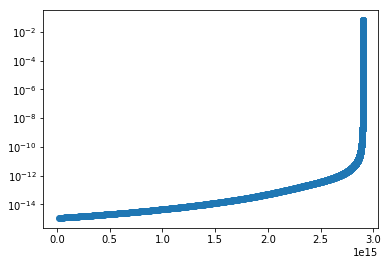

In [241]:
plt.semilogy(ttt, pressure_array,'-o')

In [242]:
max(ttt)*u.s.in_units('yr')

91948422.8995 yr

In [243]:
numpy.sum(run_time)

65.66603684425354

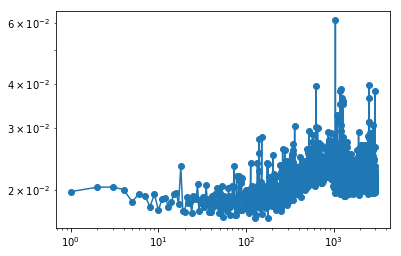

In [244]:
plt.loglog(run_time[:],'-o')

In [245]:
dir_ff_grackle = "/home/kwoksun2/grackle/src/python/examples/freefall.h5"
import h5py
f = h5py.File(dir_ff_grackle)

fdata = f['data']
grackle_data = convert_from_grackle_to_dengo_all(fdata)
grackle_data['H_2']

array([  2.02100177e-07,   2.04131597e-07,   2.06183433e-07, ...,
         1.23973752e+03,   1.24501887e+03,   1.25028297e+03])

H_2
density
force_factor
de
He_1
He_2
He_3
ge
H_1
H2_2
H2_1
H_m0
T


Text(0,0.5,u'mass density $n_x m_x / \\rho$ ')

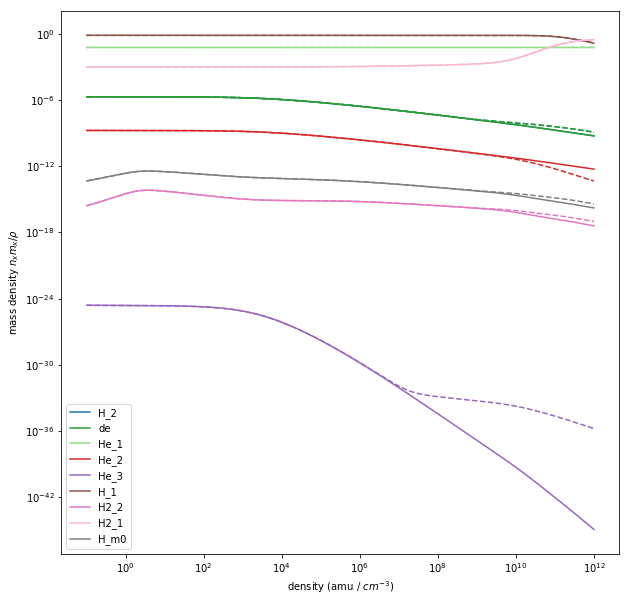

In [276]:
ic = 0
plt.figure(figsize=(10,10))
for key in all_data.keys():
    
    print(key)
    if key not in ['density','t','force_factor','ge','T']:
        data = numpy.array(all_data[key])
        data1 = grackle_data[key]
        
        plt.semilogx( density_array[:-1], data1/density_array[:-1],c=color[ic], ls = '--')
        
        plt.loglog( density_array[:-1], data/density_array[:-1],label=key, c=color[ic])
    ic += 1
plt.legend()
plt.xlabel('density (amu / $cm^{-3}$)')
plt.ylabel(r'mass density $n_x m_x / \rho$ ')

Text(0,0.5,u'mass density $n_x m_x / \\rho$ ')

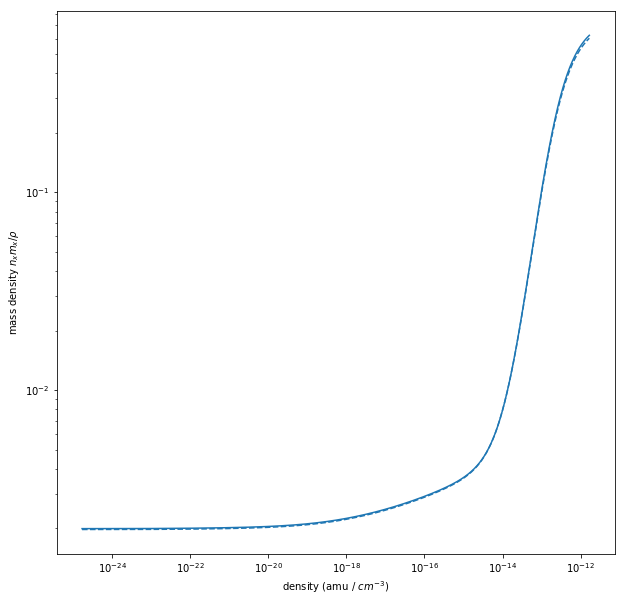

In [281]:
plt.figure(figsize=(10,10))

H2_1 =  f['data']['H2I'] 
density = numpy.array(f['data']['density'])

data = numpy.array(all_data['H2_1']) / density_array[:-1]

plt.semilogx( density_array[1:]*u.amu_cgs, H2_1/density,label=key,c=color[0],ls='--')
plt.loglog( density_array[1:]*u.amu_cgs, 2.0*data*1.00794   ,label=key,c=color[0])
plt.xlabel('density (amu / $cm^{-3}$)')
plt.ylabel(r'mass density $n_x m_x / \rho$ ')

Text(0,0.5,u'mass density  $n_x m_x / \\rho$')

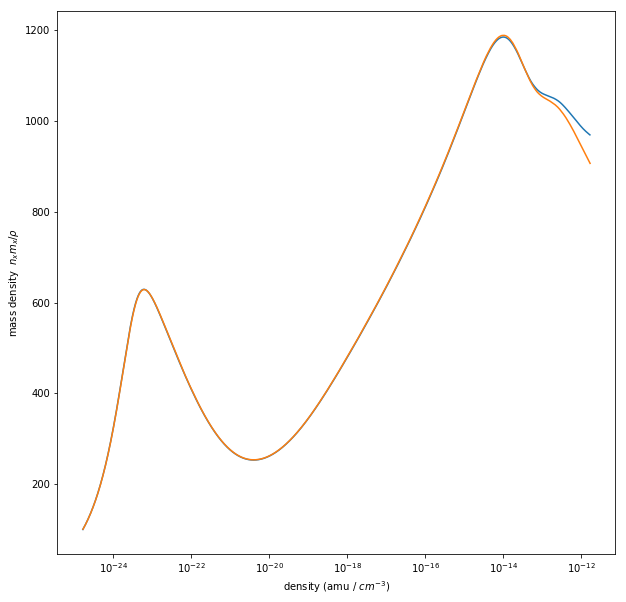

In [286]:
plt.figure(figsize=(10,10))
data0 =  f['data']['temperature'] #
plt.semilogx(density, data0, label=key)

data1 = numpy.array(all_data['T']) 
plt.semilogx( density_array[1:]*u.amu_cgs, data1,label=key)

plt.xlabel('density (amu / $cm^{-3}$)')
plt.ylabel('mass density  ' + r"$n_x m_x / \rho$")

In [ ]:
plt.semilogx(density,force_factor)

In [ ]:
plt.semilogx(density,force_factor)
data = numpy.array(all_data['force_factor']) 
plt.semilogx( density_array[1:]*u.amu_cgs, data,label=key)

In [ ]:
data = numpy.array(all_data['force_factor']) 
plt.loglog( density_array[1:][data>0], data[data>0],label=key)

In [ ]:
len(data)

In [ ]:
plt.loglog(density_array[1:], pressure_array)

In [42]:
action.tables

{'gaH2': <function dengo.primordial_cooling.gaH2>,
 'gaHI': <function dengo.primordial_cooling.gaHI>,
 'gaHe': <function dengo.primordial_cooling.gaHe>,
 'gaHp': <function dengo.primordial_cooling.gaHp>,
 'gael': <function dengo.primordial_cooling.gael>,
 'gphdl': <function dengo.primordial_cooling.gphdl>,
 'gpldl': <function dengo.primordial_cooling.gpldl>,
 'h2lte': <function dengo.primordial_cooling.h2lte>}

In [288]:
def cooling_rate_from_temp(T):
    cooling_rates = {}
    for action in primordial.cooling_actions.values():
        actionname = action.name
        for tab in action.tables:
            name = "{}_{}[i]".format(actionname, tab)
            
            temp_array = primordial.T
            
            cooling = numpy.interp(T, temp_array, action.tables[tab](primordial))
            cooling_rates[name] = cooling
    cooling_rates['T'] = T
    cooling_rates['z'] = numpy.zeros((len(T)))
#     cooling_rates = sorted(cooling_rates)
    return cooling_rates

def cooling_from_results(results, primordial, cooling_rates, T):
    
    cooling_results = {}

    for action in primordial.cooling_actions:
        cool_action = cooling_registry[action].equation
        cool_sym = cool_action.free_symbols
        
        cool_sym_name = [str(i) for i in cool_sym]
        func = lambdify(cool_sym, cool_action,'numpy') # returns a numpy-ready function
        
        
        num_var = len(cool_sym)
        len_T   = len(T)
        
        input_array = numpy.zeros(( num_var, len_T ))       
        for iii, sym_name in enumerate(cool_sym_name):
            try:
                input_array[iii, :] = results[sym_name]
            except:
                input_array[iii, :] = cooling_rates[sym_name]
        
        
        cooling_results[action] = func(*input_array)
    return cooling_results

In [289]:
T_array = all_data['T']
cooling_rates = cooling_rate_from_temp(T_array)


In [187]:
cooling_results = cooling_from_results(all_data, primordial, cooling_rates, T_array)

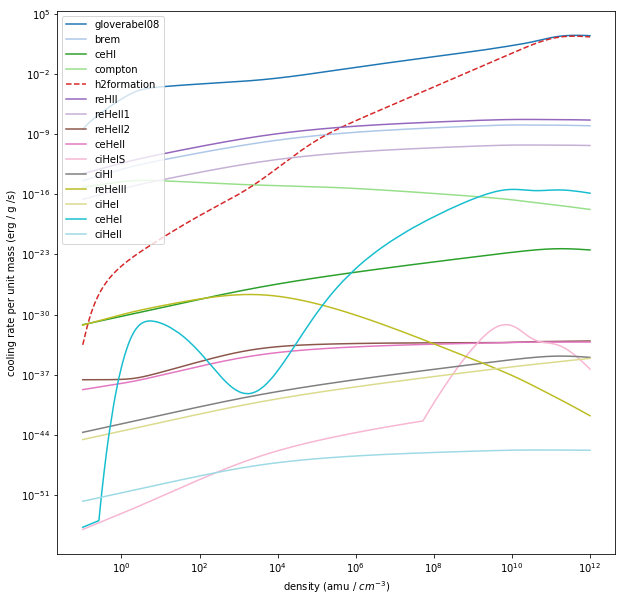

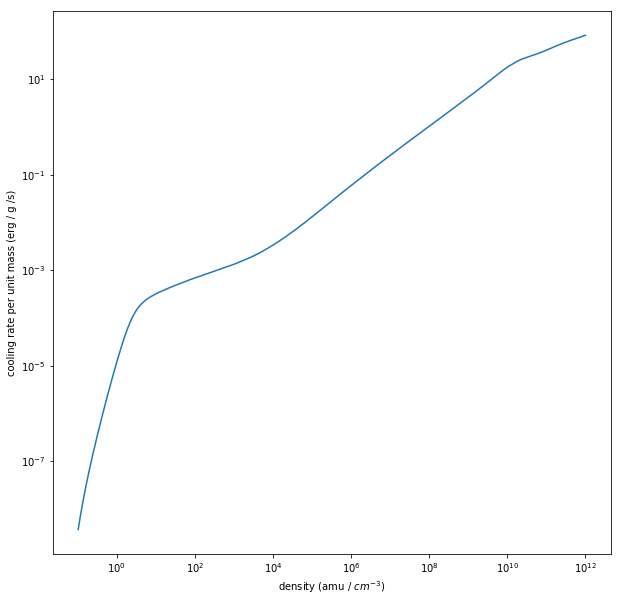

In [291]:
plt.figure(figsize=(10,10))
from matplotlib.pyplot import cm
color=cm.tab20(np.linspace(0,1,len(cooling_results.keys()) ))
net_cooling = numpy.zeros((len(T_array)))

iii = 0
for i in cooling_results.keys():
    d = cooling_results[i]
    
    net_cooling = d + net_cooling
    if i not in ['gammah']:
        if d[0] < 0:
            plt.semilogx(density_array[1:], numpy.abs(d)/density_array[1:]/ u.amu_cgs.v, label=i, c=color[iii])
        else:
            plt.loglog(density_array[1:], numpy.abs(d)/density_array[1:]/ u.amu_cgs.v, label=i, ls= '--', c=color[iii])
            
    iii += 1
plt.legend()
plt.xlabel('density (amu / $cm^{-3}$)')
plt.ylabel(r'cooling rate per unit mass (erg / g /s)')
plt.show()

plt.figure(figsize=(10,10))
plt.loglog(density_array[1:], numpy.abs(net_cooling)/density_array[1:]/ u.amu_cgs.v)
plt.xlabel('density (amu / $cm^{-3}$)')
plt.ylabel(r'cooling rate per unit mass (erg / g /s)')
plt.show()

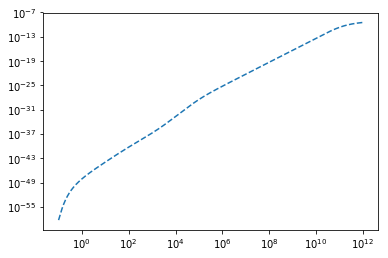

In [216]:
d = cooling_results['h2formation']
plt.loglog(density_array[1:], (d), label=i, ls= '--')

In [205]:
from matplotlib.pyplot import cm
color=cm.rainbow(np.linspace(0,1,100))

In [207]:
color[10]

array([ 0.30392157,  0.30315267,  0.98816547,  1.        ])

In [212]:
net_cooling

array([ -6.24492269e-34,  -6.64386428e-34,  -7.07071167e-34, ...,
        -1.36522391e-10,  -1.38167098e-10,  -1.39946812e-10])

# TO-DO list

1. profile the code (run-time ~ 0.02s) no matter how
2. interpolate gammaH2 (it is calculate on the fly everytime)
3. include CIE cooling

In [261]:
data/data1/1.00794

array([ 0.99828378,  0.99826619,  0.99824768, ...,  0.92884303,
        0.9283917 ,  0.92791139])